In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


# Exploring DataSet


## Import required libraries

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn import metrics

import folium
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap
from folium import plugins



In [11]:
# Adjusting Row Column setting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
# Loading the dataset

df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington    40.647    -73.972   
1     Jennifer           Manhattan       Midtown    40.754    -73.984   
2    Elisabeth           Manhattan        Harlem    40.809    -73.942   
3  LisaRoxanne            Brooklyn  Clinton Hill    40.685    -73.960   
4        Laura           Manhattan   East Harlem    40.799    -73.944   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0              0.210                               6               365  
1              0.380                               2               355  
2                NaN                               1               365  
3              4.640                               1               194  
4              0.100                               1                 0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [14]:
# dropping attribute which won't be used in further processing / analysis

drop_list = ['id', 'host_id', 'host_name', 'last_review']
df.drop(drop_list, axis = 1, inplace = True)
df.head()

name neighbourhood_group  \
0                Clean & quiet apt home by the park            Brooklyn   
1                             Skylit Midtown Castle           Manhattan   
2               THE VILLAGE OF HARLEM....NEW YORK !           Manhattan   
3                   Cozy Entire Floor of Brownstone            Brooklyn   
4  Entire Apt: Spacious Studio/Loft by central park           Manhattan   

  neighbourhood  latitude  longitude        room_type  price  minimum_nights  \
0    Kensington    40.647    -73.972     Private room    149               1   
1       Midtown    40.754    -73.984  Entire home/apt    225               1   
2        Harlem    40.809    -73.942     Private room    150               3   
3  Clinton Hill    40.685    -73.960  Entire home/apt     89               1   
4   East Harlem    40.799    -73.944  Entire home/apt     80              10   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                  9              0.210                               6   
1                 45              0.380                               2   
2                  0                NaN                               1   
3                270              4.640                               1   
4                  9              0.100                               1   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0

# Exploratory Data Analysis

In [16]:
# examination of dataset

def check_df(dataframe, head = 5):
    print('############# Shape ##############')
    print(dataframe.shape)
    print('############# Types ##############')
    print(dataframe.dtypes)
    print('############# Head ##############')
    print(dataframe.head(head))
    print('############# Tail ##############')
    print(dataframe.tail(head))
    print('############# NA values #########')
    print(dataframe.isnull().sum())
    print('############# Quantiles #########')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############# Shape ##############
(48895, 12)
############# Types ##############
name                               object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object
############# Head ##############
                                               name neighbourhood_group  \
0                Clean & quiet apt home by the park            Brooklyn   
1                             Skylit Midtown Castle           Manhattan   
2               THE VILLAGE OF HARLEM....NEW YORK !           Manhattan   
3                   Cozy Entire Floor of Brownstone            Bro

In [17]:
# Visulaizing Geographic locations on an Interactive Map

Long = -73.80
Lat = 40.80
locations = list(zip(df.latitude, df.longitude))
map_1 = folium.Map(location = [Lat, Long], zoom_start = 9)
FastMarkerCluster(data = locations).add_to(map_1)
map_1

In [18]:
# Heat Map of Geographic Distribution of locations
m = folium.Map([40.7128, -74.0060], zoom_start = 11)
HeatMap(df[['latitude', 'longitude']].dropna(), radius = 8, 
        gradient = {
            0.2: 'blue',
            0.4: 'purple',
            0.6: 'orange',
            1.0: 'red'
        }).add_to(m)
display(m)

## Fill KNN Imputers

In [19]:
rpm_df = df[['reviews_per_month']]
rpm_df.head()

reviews_per_month
0              0.210
1              0.380
2                NaN
3              4.640
4              0.100

In [21]:
rs = RobustScaler()
rpm_df = pd.DataFrame(rs.fit_transform(rpm_df), columns = rpm_df.columns)
rpm_df.head()

reviews_per_month
0             -0.279
1             -0.186
2                NaN
3              2.142
4             -0.339

In [23]:
rpm_df = pd.DataFrame(KNNImputer(n_neighbors = 5).fit_transform(rpm_df), columns = rpm_df.columns)
rpm_df.head()

reviews_per_month
0             -0.279
1             -0.186
2              0.357
3              2.142
4             -0.339

In [24]:
rpm_df = pd.DataFrame(rs.inverse_transform(rpm_df), columns = rpm_df.columns)
df[['reviews_per_month']] = rpm_df
df.head(10)

name neighbourhood_group  \
0                Clean & quiet apt home by the park            Brooklyn   
1                             Skylit Midtown Castle           Manhattan   
2               THE VILLAGE OF HARLEM....NEW YORK !           Manhattan   
3                   Cozy Entire Floor of Brownstone            Brooklyn   
4  Entire Apt: Spacious Studio/Loft by central park           Manhattan   
5         Large Cozy 1 BR Apartment In Midtown East           Manhattan   
6                                   BlissArtsSpace!            Brooklyn   
7                  Large Furnished Room Near B'way            Manhattan   
8                Cozy Clean Guest Room - Family Apt           Manhattan   
9                Cute & Cozy Lower East Side 1 bdrm           Manhattan   

        neighbourhood  latitude  longitude        room_type  price  \
0          Kensington    40.647    -73.972     Private room    149   
1             Midtown    40.754    -73.984  Entire home/apt    225   
2              Harlem    40.809    -73.942     Private room    150   
3        Clinton Hill    40.685    -73.960  Entire home/apt     89   
4         East Harlem    40.799    -73.944  Entire home/apt     80   
5         Murray Hill    40.748    -73.975  Entire home/apt    200   
6  Bedford-Stuyvesant    40.687    -73.956     Private room     60   
7      Hell's Kitchen    40.765    -73.985     Private room     79   
8     Upper West Side    40.802    -73.967     Private room     79   
9           Chinatown    40.713    -73.990  Entire home/apt    150   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9              0.210   
1               1                 45              0.380   
2               3                  0              1.373   
3               1                270              4.640   
4              10                  9              0.100   
5               3                 74              0.590   
6              45                 49              0.400   
7               2                430              3.470   
8               2                118              0.990   
9               1                160              1.330   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365  
3                               1               194  
4                               1                 0  
5                               1               129  
6                               1                 0  
7                               1               220  
8                               1                 0  
9                               4               188

In [25]:
df.isnull().sum()

name                              16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

## Capturing and Detecting Numeric and Categorical Variables

In [35]:
"""
Returns the names of categorical, numeric and categorical but cardian variables in the data set

Parameters : 
dataframe - dataframe - Variable anems of the dataframe to be taken
cat_th - int, optional - class threshold for numeric but categorical variables
car_th - int, optional - class threshold for categorical but cardinal variables

Returns :
cat_cols - list - Categorical variable list
num_cols - list - Numeric variable list
cat_but_car - list - List of cardinal variables with categorical appearance

"""
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Obervations : {dataframe.shape[0]}")
    print(f"Variables : {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car : {len(cat_but_car)}')
    print(f'num_but_cat : {len(num_but_cat)}')
    
    
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [36]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Obervations : 48895
Variables : 12
cat_cols: 2
num_cols: 8
cat_but_car : 2
num_but_cat : 0


In [37]:
cat_cols

['neighbourhood_group', 'room_type']

In [38]:
num_cols

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [39]:
cat_but_car

['name', 'neighbourhood']

In [40]:
num_but_cat

[]

## Analysis of Categorical variables

In [41]:
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({
        col_name : dataframe[col_name].value_counts(),
        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)
    }))
    if plot:
        plt.figure(figsize=(12, 6))
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block = True)

                     neighbourhood_group  Ratio
neighbourhood_group                            
Manhattan                          21661 44.301
Brooklyn                           20104 41.117
Queens                              5666 11.588
Bronx                               1091  2.231
Staten Island                        373  0.763


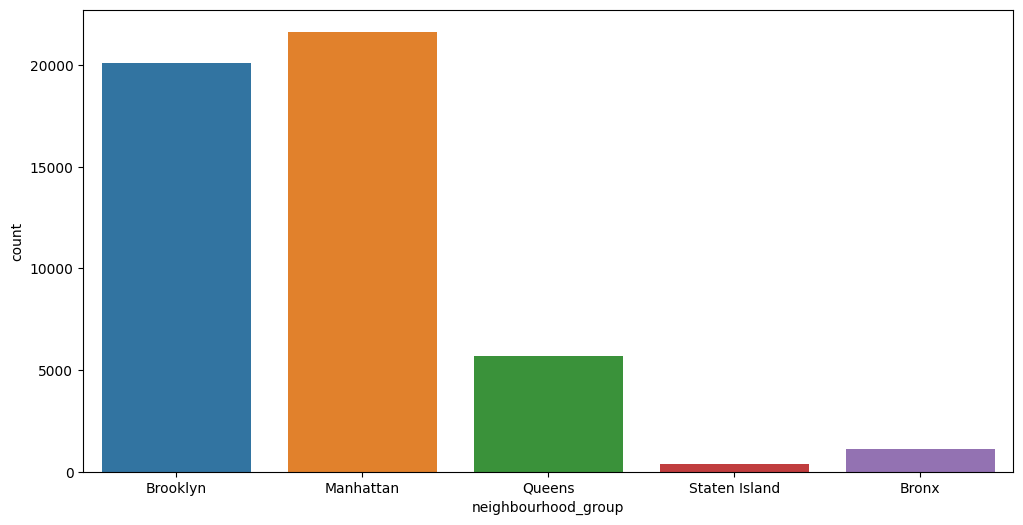

                 room_type  Ratio
room_type                        
Entire home/apt      25409 51.966
Private room         22326 45.661
Shared room           1160  2.372


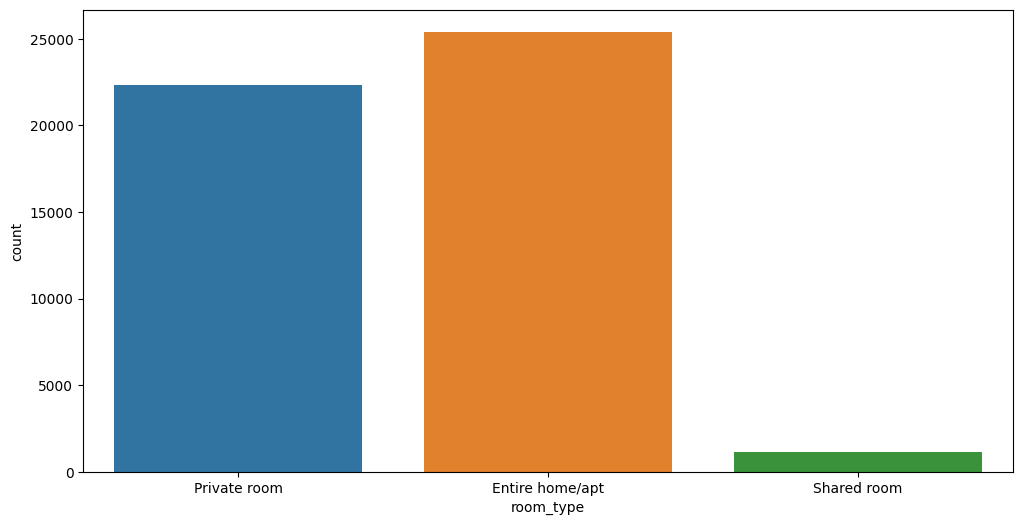

In [42]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

## Analysis of Numerical Variables

In [43]:
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        dataframe[numerical_col].hist(bins = 20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block = True)

count   48895.000
mean       40.729
std         0.055
min        40.500
5%         40.646
10%        40.668
20%        40.685
30%        40.697
40%        40.712
50%        40.723
60%        40.738
70%        40.756
80%        40.771
90%        40.805
95%        40.826
99%        40.865
max        40.913
Name: latitude, dtype: float64


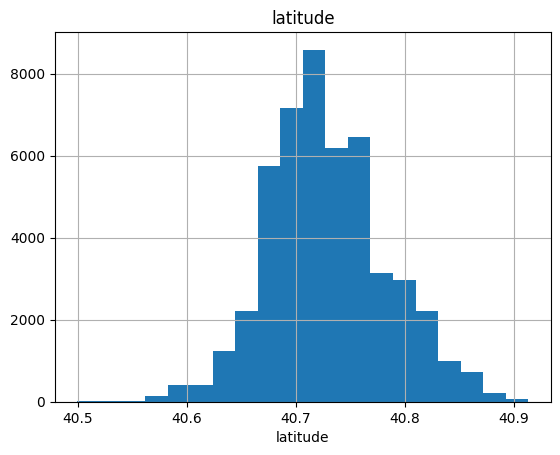

count   48895.000
mean      -73.952
std         0.046
min       -74.244
5%        -74.004
10%       -73.997
20%       -73.987
30%       -73.979
40%       -73.964
50%       -73.956
60%       -73.949
70%       -73.941
80%       -73.928
90%       -73.908
95%       -73.866
99%       -73.777
max       -73.713
Name: longitude, dtype: float64


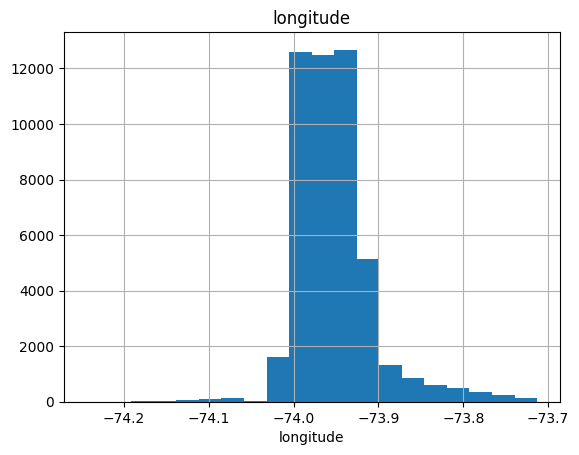

count   48895.000
mean      152.721
std       240.154
min         0.000
5%         40.000
10%        49.000
20%        60.000
30%        75.000
40%        90.000
50%       106.000
60%       130.000
70%       155.000
80%       200.000
90%       269.000
95%       355.000
99%       799.000
max     10000.000
Name: price, dtype: float64


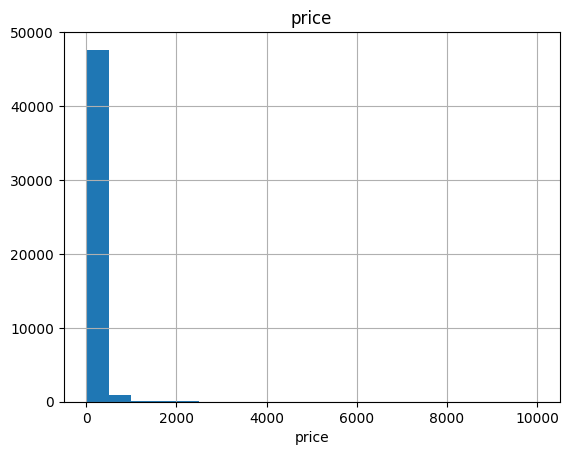

count   48895.000
mean        7.030
std        20.511
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         2.000
50%         3.000
60%         3.000
70%         4.000
80%         6.000
90%        28.000
95%        30.000
99%        45.000
max      1250.000
Name: minimum_nights, dtype: float64


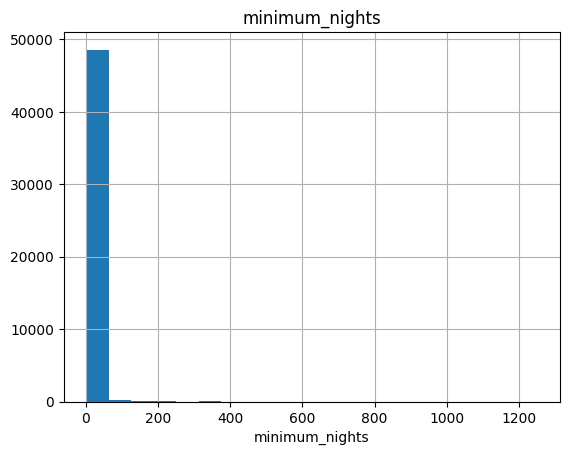

count   48895.000
mean       23.274
std        44.551
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         1.000
40%         3.000
50%         5.000
60%         9.000
70%        17.000
80%        33.000
90%        70.000
95%       114.000
99%       214.000
max       629.000
Name: number_of_reviews, dtype: float64


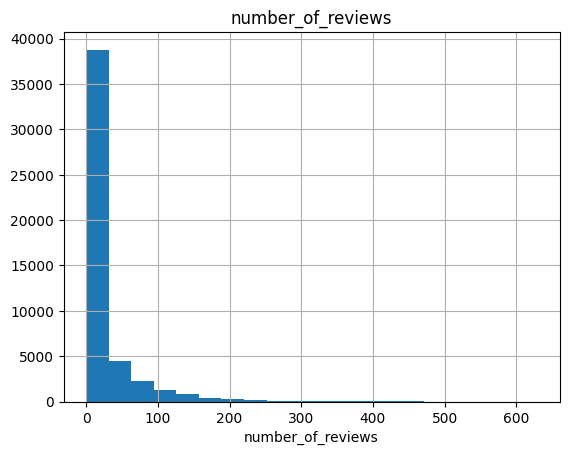

count   48895.000
mean        1.373
std         1.498
min         0.010
5%          0.050
10%         0.080
20%         0.190
30%         0.390
40%         0.730
50%         1.220
60%         1.373
70%         1.373
80%         2.000
90%         3.250
95%         4.310
99%         6.800
max        58.500
Name: reviews_per_month, dtype: float64


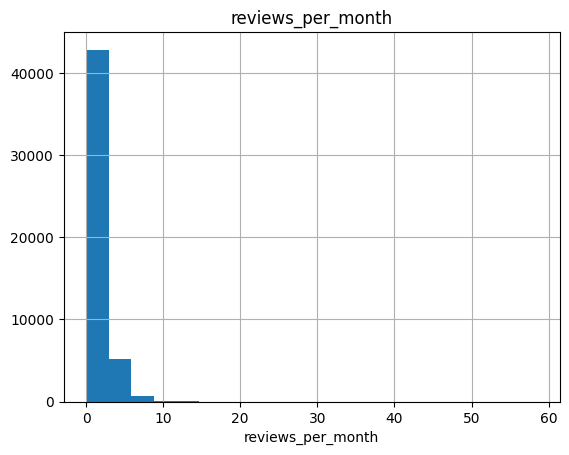

count   48895.000
mean        7.144
std        32.953
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         1.000
60%         1.000
70%         2.000
80%         3.000
90%         5.000
95%        15.000
99%       232.000
max       327.000
Name: calculated_host_listings_count, dtype: float64


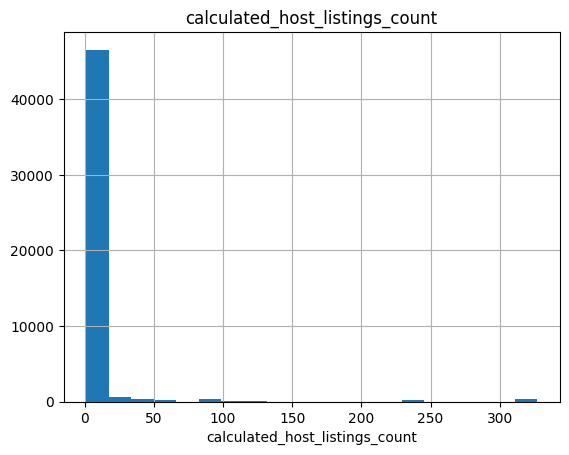

count   48895.000
mean      112.781
std       131.622
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         8.000
50%        45.000
60%        92.000
70%       179.000
80%       272.000
90%       337.000
95%       359.000
99%       365.000
max       365.000
Name: availability_365, dtype: float64


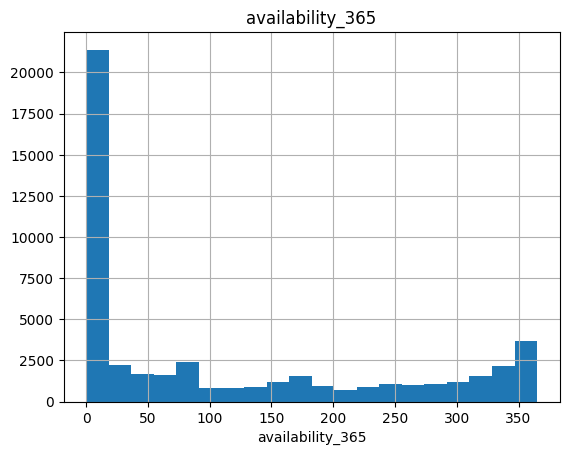

In [44]:
for col in num_cols:
    num_summary(df, col, plot = True)

## Analysis of Categorical variables by target

In [45]:
def target_summary_with_cat(dataframe, target, categorical_col, plot = False):
    print(pd.DataFrame({'TARGET_MEAN' : dataframe.groupby(categorical_col)[target].mean()}), end = '\n\n\n')
    
    if plot:
        sns.barplot(x = categorical_col, y = target, data = dataframe)
        plt.show(block = True)
        

                     TARGET_MEAN
neighbourhood_group             
Bronx                     87.497
Brooklyn                 124.383
Manhattan                196.876
Queens                    99.518
Staten Island            114.812




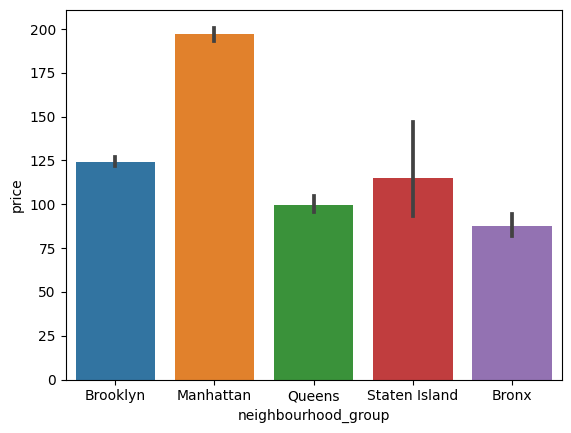

                 TARGET_MEAN
room_type                   
Entire home/apt      211.794
Private room          89.781
Shared room           70.128




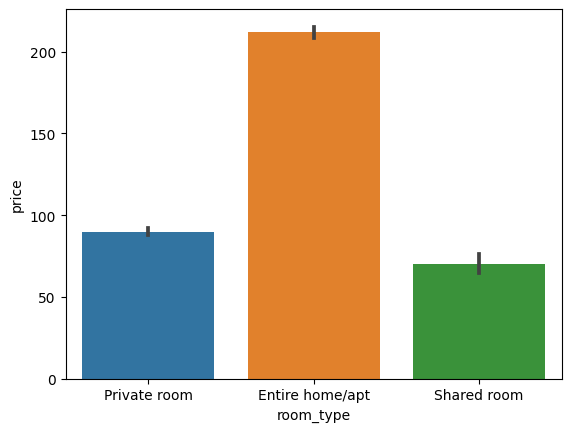

In [46]:
for col in cat_cols:
    target_summary_with_cat(df, 'price', col, plot=  True)

## Analysis of Numeric Variables by Target

In [47]:
def target_summary_with_num(dataframe, target, numerical_col, plot = False):
    print(pd.DataFrame({ numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end = '\n\n\n')
    
    if plot:
        sns.barplot(x = target, y = numerical_col, data = dataframe)
        plt.show(block = True)
        

In [48]:
for col in num_cols:
    target_summary_with_num(df, 'price', col, plot = False)

       latitude_mean
price               
0             40.712
10            40.729
11            40.738
12            40.715
13            40.631
...              ...
7703          40.768
8000          40.691
8500          40.722
9999          40.742
10000         40.758

[674 rows x 1 columns]


       longitude_mean
price                
0             -73.926
10            -73.936
11            -73.926
12            -73.970
13            -74.126
...               ...
7703          -73.960
8000          -73.967
8500          -74.006
9999          -73.970
10000         -73.954

[674 rows x 1 columns]


       price_mean
price            
0           0.000
10         10.000
11         11.000
12         12.000
13         13.000
...           ...
7703     7703.000
8000     8000.000
8500     8500.000
9999     9999.000
10000   10000.000

[674 rows x 1 columns]


       minimum_nights_mean
price                     
0                    7.364
10                   4.059
11                   

## Corrleation Analysis

In [68]:
def high_correlated_cols(dataframe, plot = False, corr_th = 0.70):
    corr = dataframe.corr(numeric_only=True)
    cor_matrix = corr.abs()
    upper_traingle_matrix = cor_matrix.where(
        np.triu(np.ones(cor_matrix.shape), k = 1).astype(bool)
    )
    drop_list = [col for col in upper_traingle_matrix.columns if any(upper_traingle_matrix[col] > corr_th)]
    
    if plot: 
        sns.set(rc = {'figure.figsize': (12, 12)})
        sns.heatmap(corr, cmap = 'RdBu', annot = True, fmt = ".2f")
        plt.show()
    return drop_list

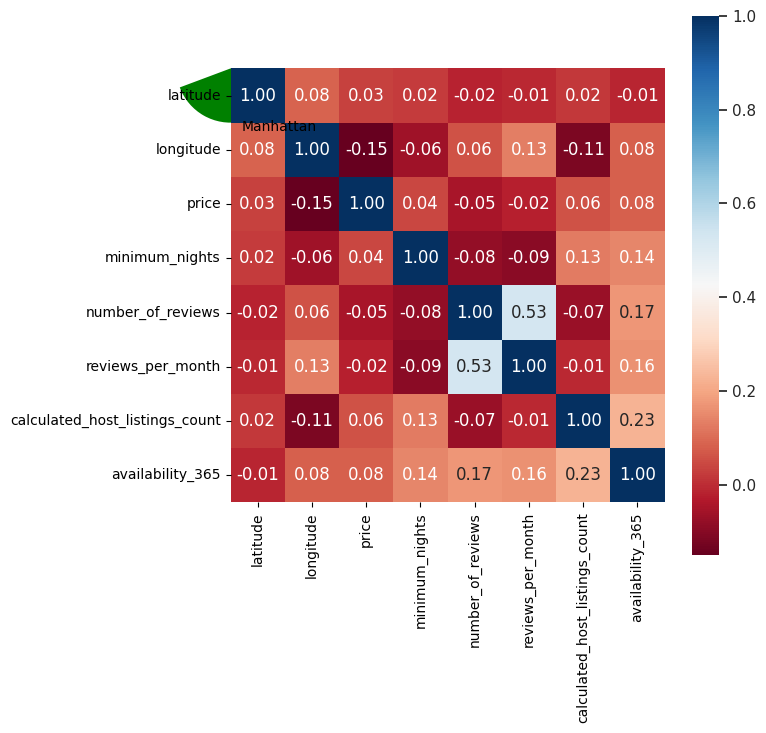

[]

In [69]:
high_correlated_cols(df, plot = True)

In [70]:
corr = df[num_cols].corr()
corr

latitude  longitude  price  minimum_nights  \
latitude                           1.000      0.085  0.034           0.025   
longitude                          0.085      1.000 -0.150          -0.063   
price                              0.034     -0.150  1.000           0.043   
minimum_nights                     0.025     -0.063  0.043           1.000   
number_of_reviews                 -0.015      0.059 -0.048          -0.080   
reviews_per_month                 -0.009      0.132 -0.022          -0.092   
calculated_host_listings_count     0.020     -0.115  0.057           0.128   
availability_365                  -0.011      0.083  0.082           0.144   

                                number_of_reviews  reviews_per_month  \
latitude                                   -0.015             -0.009   
longitude                                   0.059              0.132   
price                                      -0.048             -0.022   
minimum_nights                             -0.080             -0.092   
number_of_reviews                           1.000              0.530   
reviews_per_month                           0.530              1.000   
calculated_host_listings_count             -0.072             -0.007   
availability_365                            0.172              0.163   

                                calculated_host_listings_count  \
latitude                                                 0.020   
longitude                                               -0.115   
price                                                    0.057   
minimum_nights                                           0.128   
number_of_reviews                                       -0.072   
reviews_per_month                                       -0.007   
calculated_host_listings_count                           1.000   
availability_365                                         0.226   

                                availability_365  
latitude                                  -0.011  
longitude                                  0.083  
price                                      0.082  
minimum_nights                             0.144  
number_of_reviews                          0.172  
reviews_per_month                          0.163  
calculated_host_listings_count             0.226  
availability_365                           1.000

## Distribution of depedent variable

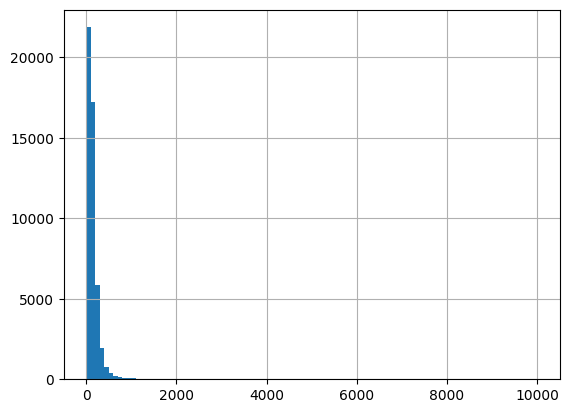

In [51]:
df["price"].hist(bins=100)
plt.show(block = True)

## Examining the Logarithm of the dependent variable

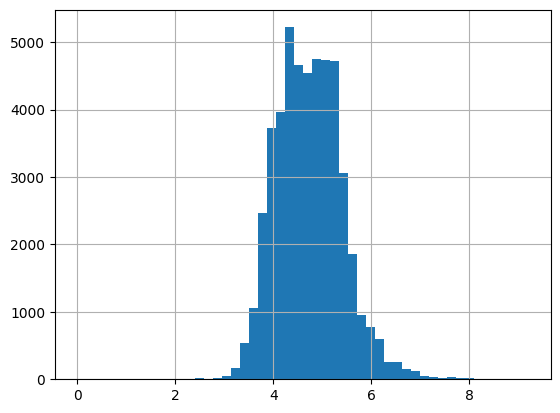

In [52]:
np.log1p(df['price']).hist(bins=50)
plt.show(block = True)

## Visualizing Location on neighbourhood group and Room type

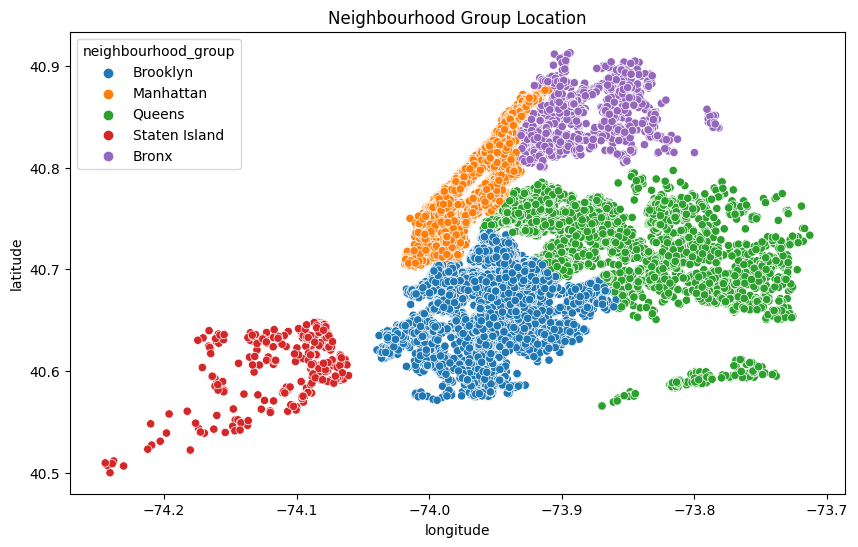

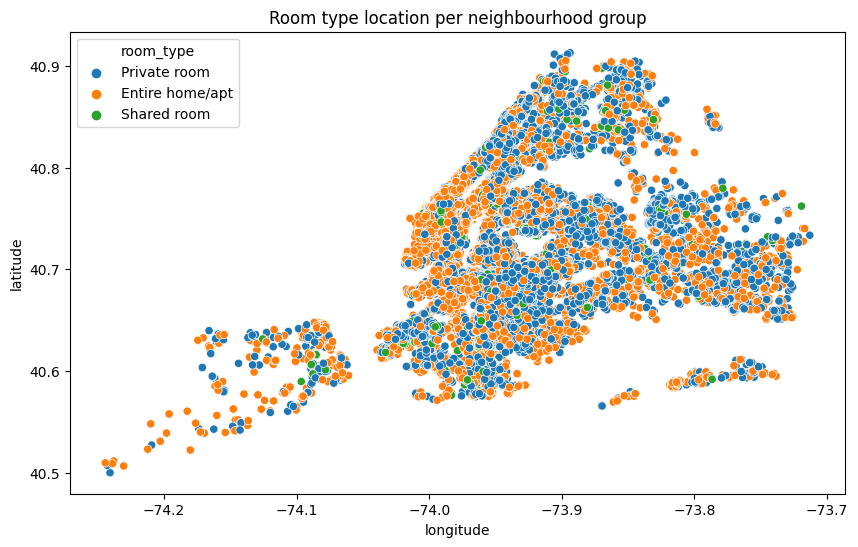

In [54]:
title = 'Neighbourhood Group Location'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x = 'longitude',
    y = 'latitude',
    hue = 'neighbourhood_group',
    data = df
).set_title(title)
plt.ioff()

title = 'Room type location per neighbourhood group'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x = 'longitude',
    y = 'latitude',
    hue = 'room_type',
    data = df
).set_title(title)
plt.ioff()

## Geographical Distribution of Prices

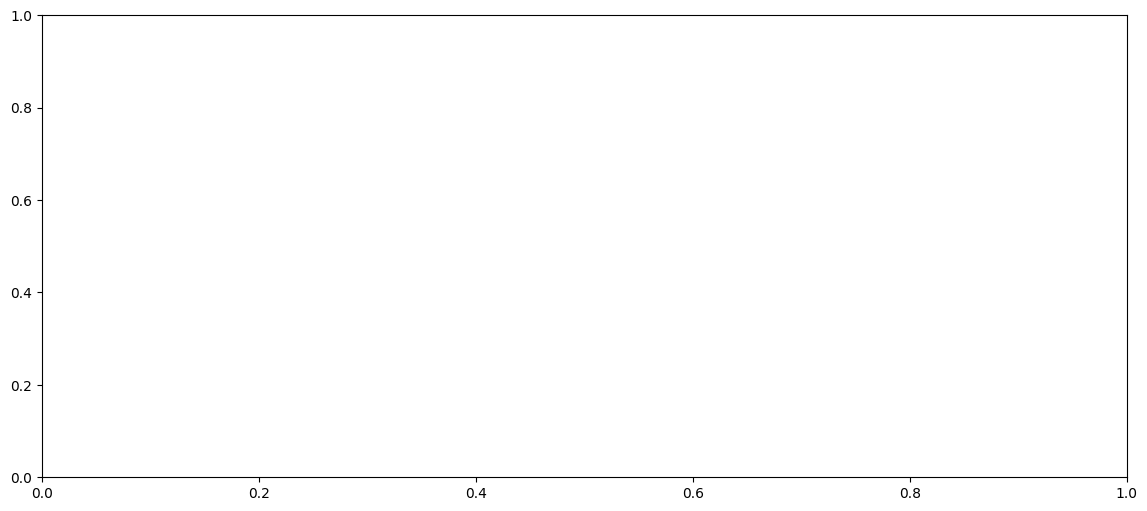

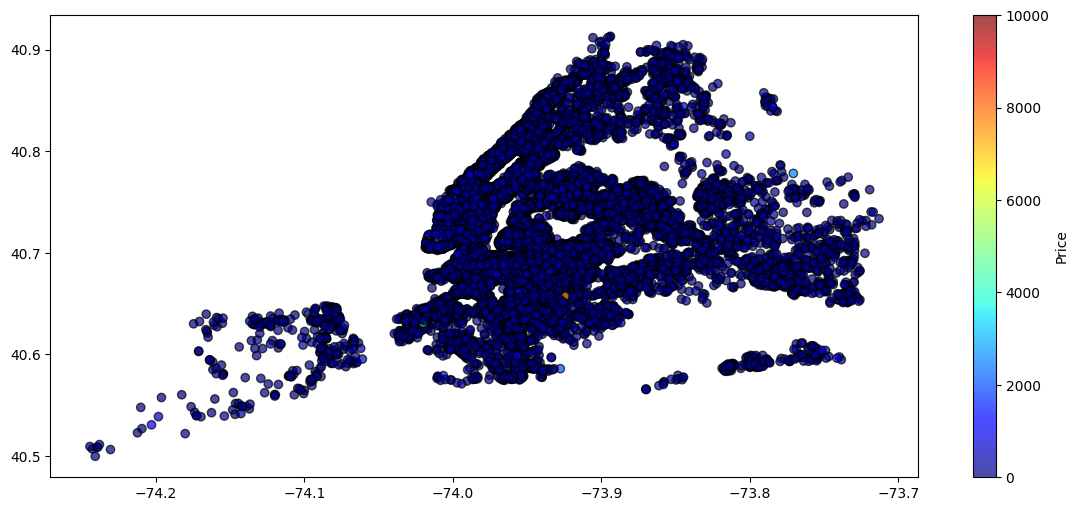

In [56]:
plt.figure(figsize=(14 , 6))
plt.scatter(df.longitude, df.latitude, c = df.price, alpha = 0.7, cmap ='jet', edgecolor = 'black')
cbar = plt.colorbar()
cbar.set_label('Price')
plt.show()

## Geographical distribution of Availability

<Figure size 1400x600 with 0 Axes>

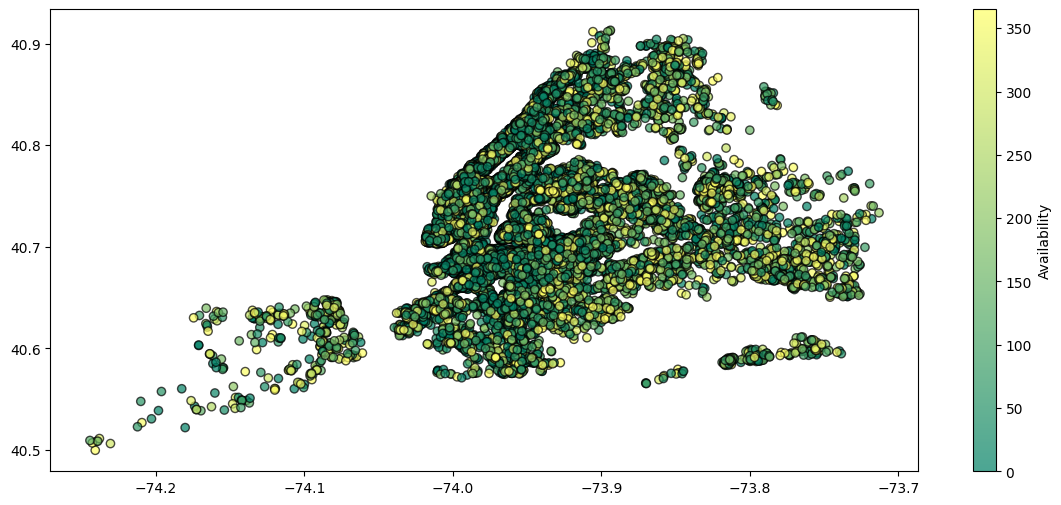

In [59]:
plt.figure(figsize=(14, 6))
plt.scatter(df.longitude, df.latitude, c = df.availability_365, alpha = 0.7, cmap = 'summer', edgecolor = 'black')
c_bar = plt.colorbar()
c_bar.set_label('Availability')
plt.show()

## Distribution by Neighbourhood Group

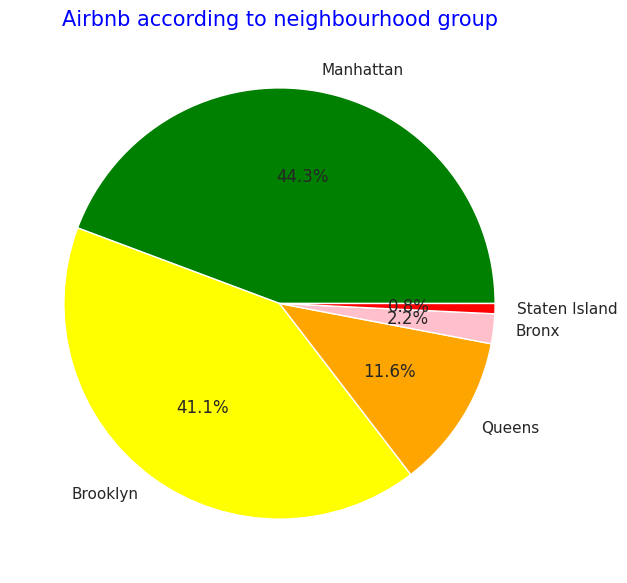

In [71]:
labels = df.neighbourhood_group.value_counts().index
colors = ['green', 'yellow', 'orange', 'pink', 'red']
explode = [0, 0, 0, 0, 0]
sizes = df.neighbourhood_group.value_counts().values

plt.figure(0, figsize = (7, 7))
plt.pie(sizes, explode = explode, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('Airbnb according to neighbourhood group', color = 'blue', fontsize = 15)
plt.show()

## Price distribution by room type in neighbourhood group

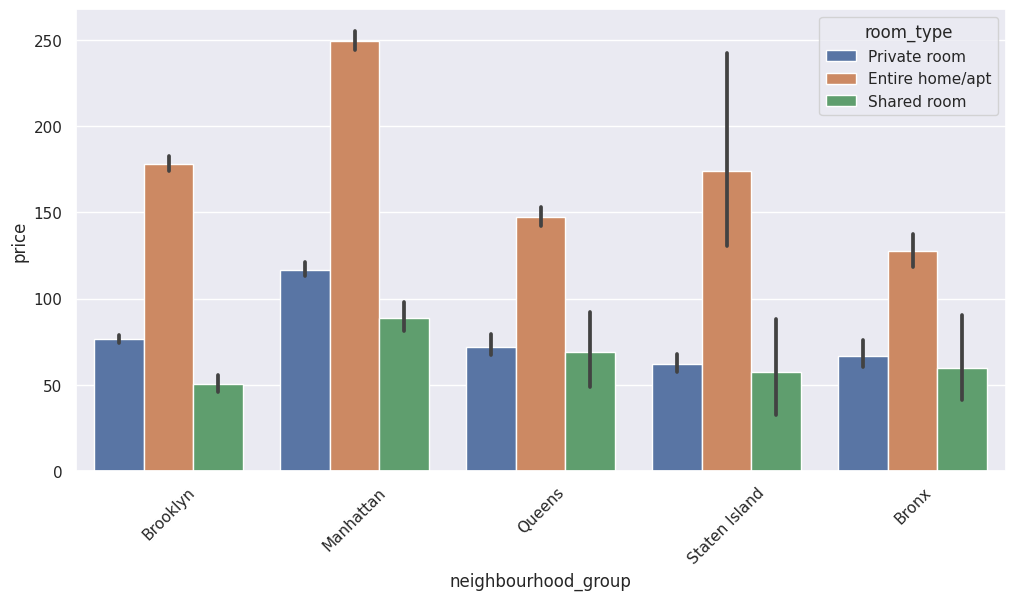

In [72]:
plt.figure(figsize=(12, 6))
sns.barplot(x = 'neighbourhood_group', y = 'price', hue = 'room_type', data = df)
plt.xticks(rotation=45)
plt.show()

## Comparative display of median monthly reviews by Neighbourhoodgroup

/tmp/ipykernel_36/3386821599.py:2: FutureWarning: The provided callable <function median at 0x7d3abbaf15a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  results = df.groupby(['neighbourhood_group'])['reviews_per_month'].aggregate(np.median).reset_index().sort_values('reviews_per_month')


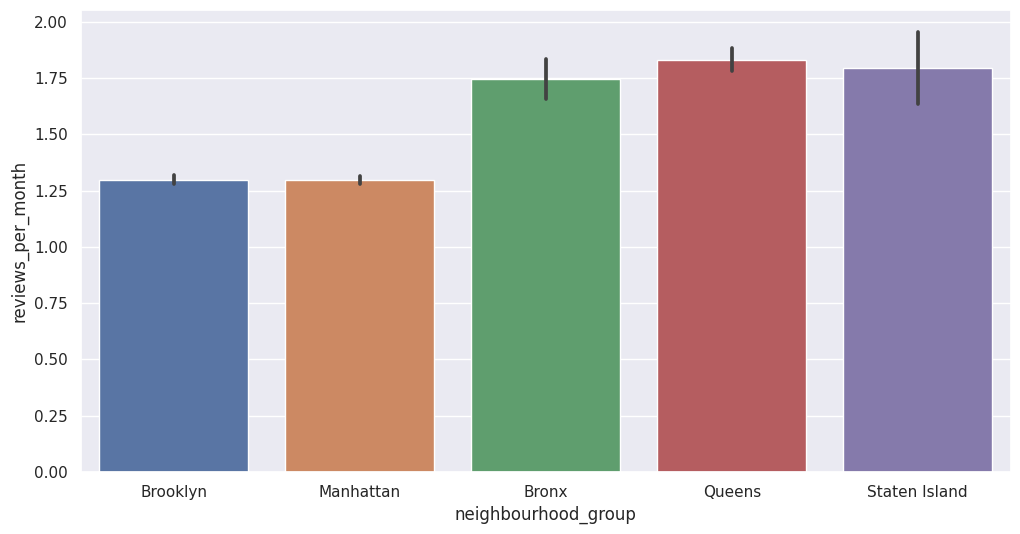

In [73]:
plt.figure(figsize=(12, 6))
results = df.groupby(['neighbourhood_group'])['reviews_per_month'].aggregate(np.median).reset_index().sort_values('reviews_per_month')

sns.barplot(
    x = 'neighbourhood_group',
    y = 'reviews_per_month',
    data = df,
    order = results['neighbourhood_group']
)
plt.show()

## Comparision of minimum stay nights by neighbourhood group

<Figure size 1200x600 with 0 Axes>

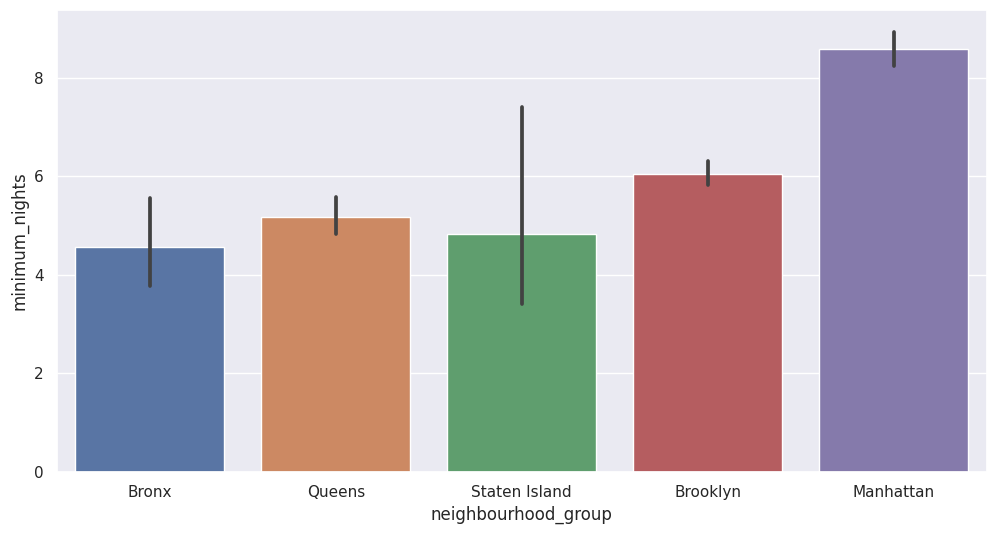

In [76]:
plt.figure(figsize=(12, 6))

result = df.groupby(['neighbourhood_group'])['minimum_nights'].aggregate("median").reset_index().sort_values('minimum_nights')

sns.barplot(
    x = 'neighbourhood_group',
    y = 'minimum_nights',
    data = df,
    order = result['neighbourhood_group']
)
plt.show()

## Comparision of number of review by neighbourhood

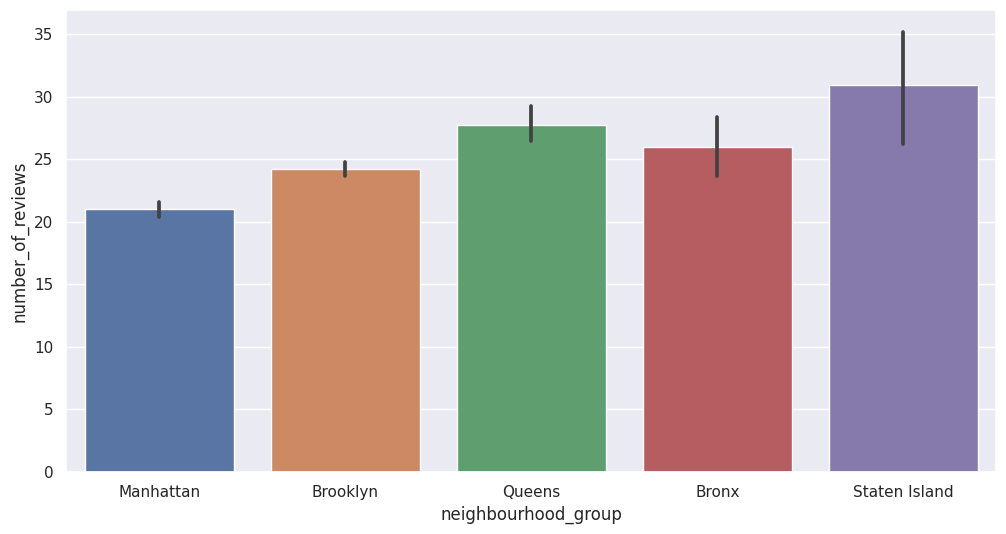

In [78]:
plt.figure(figsize=(12, 6))
result = df.groupby(['neighbourhood_group'])['number_of_reviews'].aggregate("median").reset_index().sort_values('number_of_reviews')

sns.barplot(
    x = 'neighbourhood_group',
    y = 'number_of_reviews',
    data = df,
    order = result['neighbourhood_group']
)
plt.show()

## Comparision of host listing count by neighbourhood group

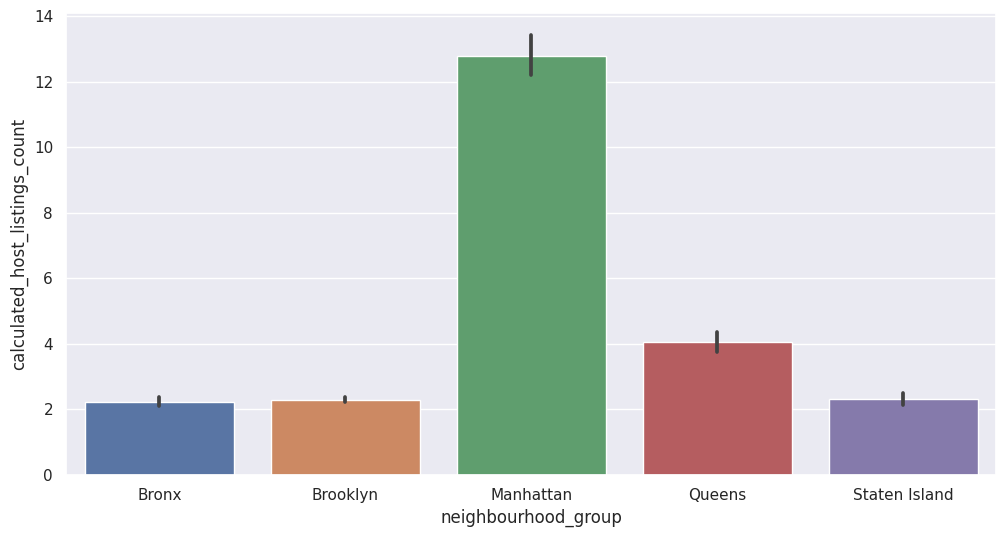

In [79]:
plt.figure(figsize=(12, 6))
result = df.groupby(['neighbourhood_group'])['calculated_host_listings_count'].aggregate("median").reset_index().sort_values('calculated_host_listings_count')

sns.barplot(
    x = 'neighbourhood_group',
    y = 'calculated_host_listings_count',
    data = df,
    order = result['neighbourhood_group']
)
plt.show()

## Comparison of yearly availability by neighbourhood group

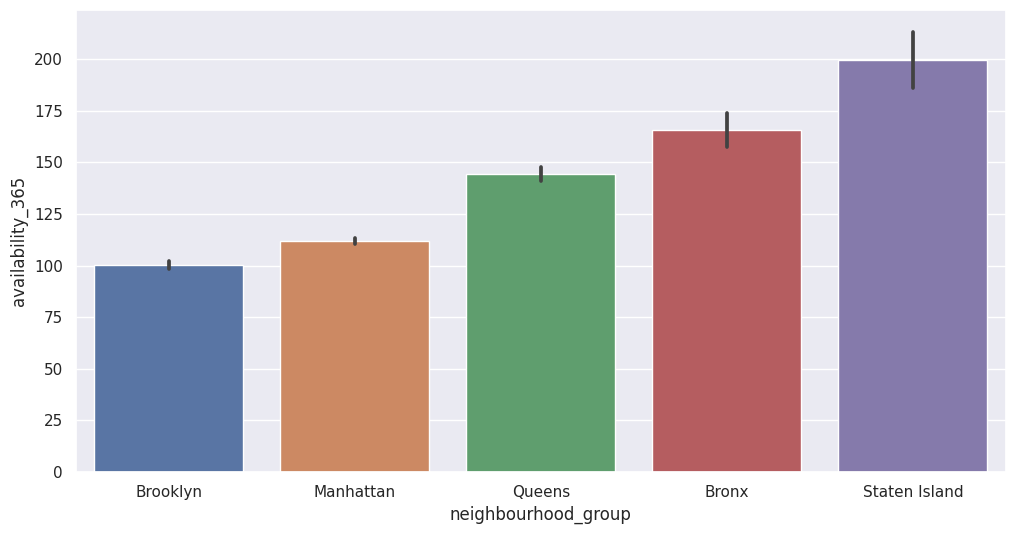

In [81]:
plt.figure(figsize=(12, 6))
result = df.groupby(['neighbourhood_group'])['availability_365'].aggregate("median").reset_index().sort_values('availability_365')

sns.barplot(
    x = 'neighbourhood_group',
    y = 'availability_365',
    data = df,
    order = result['neighbourhood_group']
)
plt.show()

## Comparison of number of reviews by Room Type

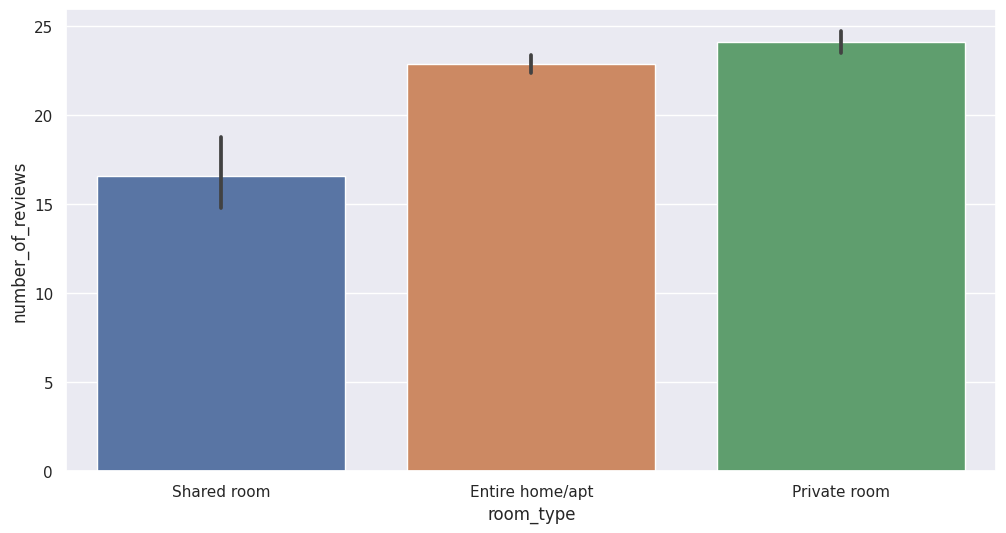

In [82]:
plt.figure(figsize=(12, 6))
result = df.groupby(['room_type'])['number_of_reviews'].aggregate("median").reset_index().sort_values('number_of_reviews')

sns.barplot(
    x = 'room_type',
    y = 'number_of_reviews',
    data = df,
    order = result['room_type']
)
plt.show()

## Comparison of monthly reviews by Room Type

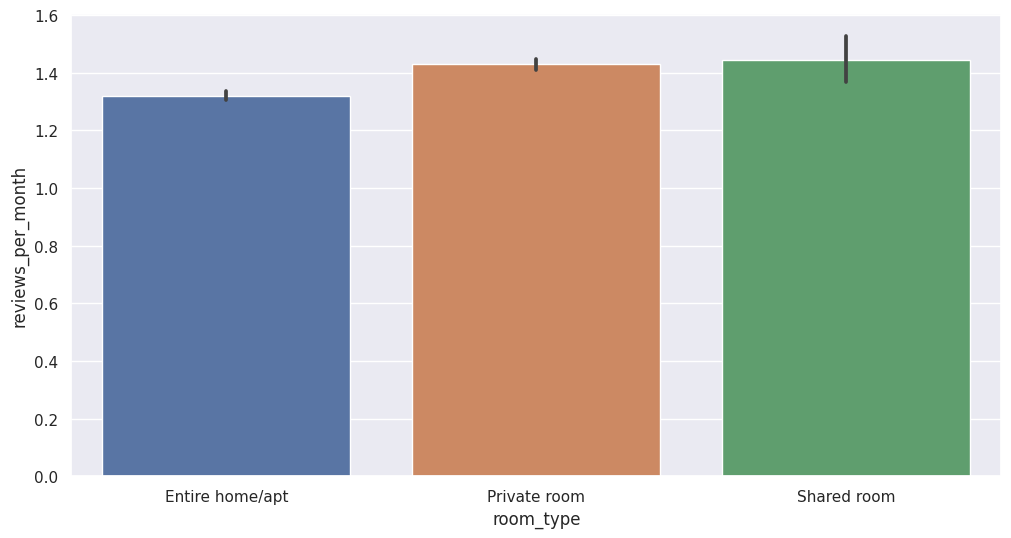

In [83]:
plt.figure(figsize=(12, 6))
result = df.groupby(['room_type'])['reviews_per_month'].aggregate("median").reset_index().sort_values('reviews_per_month')

sns.barplot(
    x = 'room_type',
    y = 'reviews_per_month',
    data = df,
    order = result['room_type']
)
plt.show()

## Comparison of host listing counts by Room Type

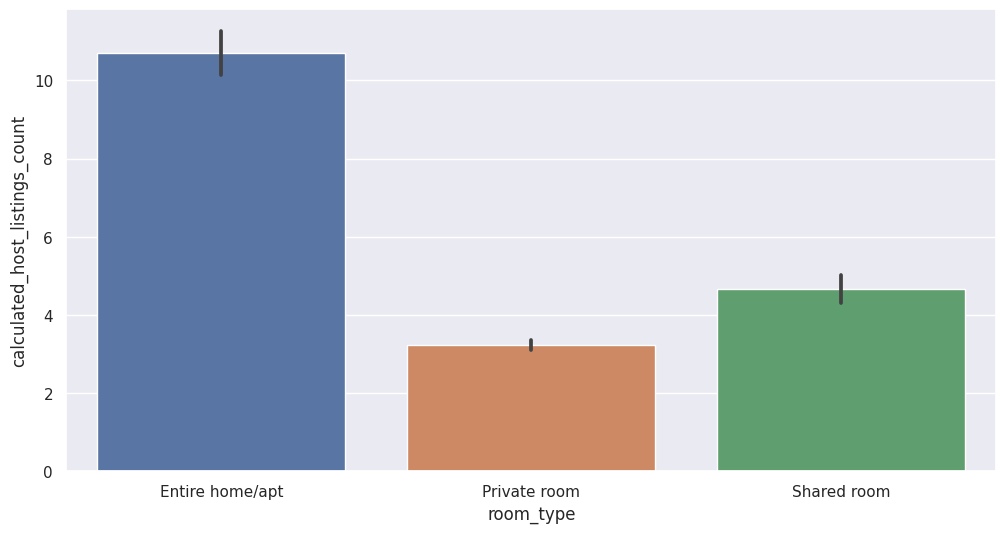

In [84]:
plt.figure(figsize=(12, 6))
result = df.groupby(['room_type'])['calculated_host_listings_count'].aggregate("median").reset_index().sort_values('calculated_host_listings_count')

sns.barplot(
    x = 'room_type',
    y = 'calculated_host_listings_count',
    data = df,
    order = result['room_type']
)
plt.show()

## Comparison of yearly availability by Room Type

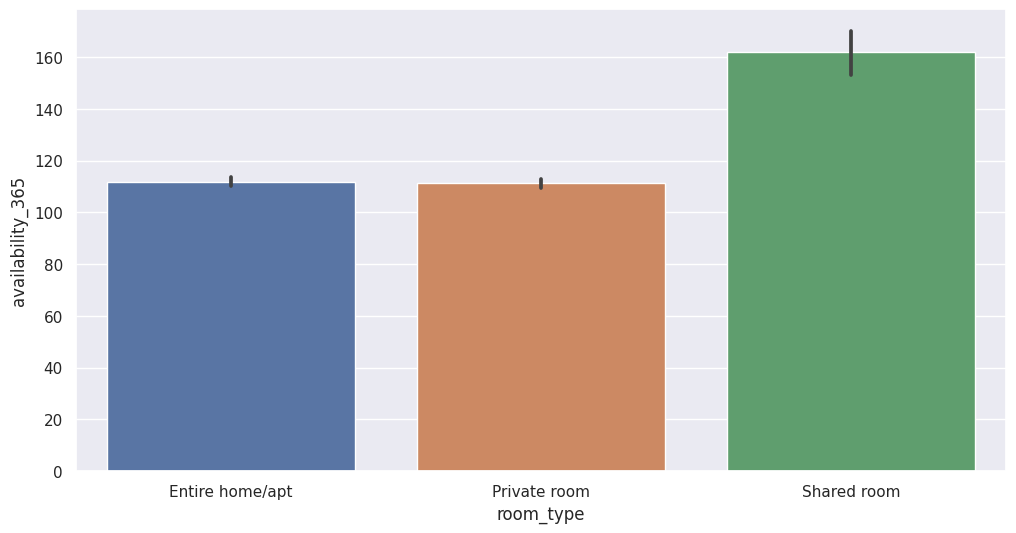

In [85]:
plt.figure(figsize=(12, 6))
result = df.groupby(['room_type'])['availability_365'].aggregate("median").reset_index().sort_values('availability_365')

sns.barplot(
    x = 'room_type',
    y = 'availability_365',
    data = df,
    order = result['room_type']
)
plt.show()

# Outilers Analysis

In [86]:
drop_list_2 = ['name', 'neighbourhood']
df.drop(drop_list_2, axis = 1, inplace = True)
df.head()

neighbourhood_group  latitude  longitude        room_type  price  \
0            Brooklyn    40.647    -73.972     Private room    149   
1           Manhattan    40.754    -73.984  Entire home/apt    225   
2           Manhattan    40.809    -73.942     Private room    150   
3            Brooklyn    40.685    -73.960  Entire home/apt     89   
4           Manhattan    40.799    -73.944  Entire home/apt     80   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9              0.210   
1               1                 45              0.380   
2               3                  0              1.373   
3               1                270              4.640   
4              10                  9              0.100   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365  
3                               1               194  
4                               1                 0

In [91]:
def outlier_thresholds(dataframe, col_name, q_1 = 0.05, q_3=0.95):
    quartile_1 = dataframe[col_name].quantile(q_1)
    quartile_3 = dataframe[col_name].quantile(q_3)
    interquantile_range = quartile_3 - quartile_1
    up_limit = quartile_3 + 1.5 * interquantile_range
    low_limit = quartile_1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    


In [92]:
for col in num_cols:
    print(col, check_outlier(df, col))

latitude False
longitude True
price True
minimum_nights True
number_of_reviews True
reviews_per_month True
calculated_host_listings_count True
availability_365 False


In [93]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
    

/tmp/ipykernel_36/129228982.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-432.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_36/129228982.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-42.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [94]:
for col in num_cols:
    print(col, check_outlier(df, col))

latitude False
longitude False
price False
minimum_nights False
number_of_reviews False
reviews_per_month False
calculated_host_listings_count False
availability_365 False


# Missing value analysis

In [96]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    
    ratio = (dataframe[na_columns].isnull().sum()/dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys = ['n_miss', 'ratio'])
    
    print(missing_df, end = '\n')
    
    if na_name:
        return na_columns
    
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# Rare analysis

In [97]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({'COUNT': dataframe[col].value_counts(),
                           'RATIO': dataframe[col].value_counts() / len(dataframe),
                           'TARGET_MEAN': dataframe.groupby(col)[target].mean()
                           }),
              end = '\n\n\n'
             )

rare_analyser(df, 'price', cat_cols)

neighbourhood_group : 5
                     COUNT  RATIO  TARGET_MEAN
neighbourhood_group                           
Bronx                 1091  0.022       85.806
Brooklyn             20104  0.411      119.493
Manhattan            21661  0.443      183.362
Queens                5666  0.116       96.176
Staten Island          373  0.008      102.031


room_type : 3
                 COUNT  RATIO  TARGET_MEAN
room_type                                 
Entire home/apt  25409  0.520      198.705
Private room     22326  0.457       86.097
Shared room       1160  0.024       68.628




In [99]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and 
                    (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis = None)
                   ]
    for var in rare_columns:
        tmp  = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp  < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

rare_encoder(df, 0.01)

neighbourhood_group  latitude  longitude        room_type   price  \
0                Brooklyn    40.647    -73.972     Private room 149.000   
1               Manhattan    40.754    -73.984  Entire home/apt 225.000   
2               Manhattan    40.809    -73.942     Private room 150.000   
3                Brooklyn    40.685    -73.960  Entire home/apt  89.000   
4               Manhattan    40.799    -73.944  Entire home/apt  80.000   
...                   ...       ...        ...              ...     ...   
48890            Brooklyn    40.679    -73.950     Private room  70.000   
48891            Brooklyn    40.702    -73.933     Private room  40.000   
48892           Manhattan    40.815    -73.949  Entire home/apt 115.000   
48893           Manhattan    40.758    -73.991      Shared room  55.000   
48894           Manhattan    40.764    -73.989     Private room  90.000   

       minimum_nights  number_of_reviews  reviews_per_month  \
0               1.000                  9              0.210   
1               1.000                 45              0.380   
2               3.000                  0              1.373   
3               1.000                270              4.640   
4              10.000                  9              0.100   
...               ...                ...                ...   
48890           2.000                  0              1.373   
48891           4.000                  0              1.373   
48892          10.000                  0              1.373   
48893           1.000                  0              1.373   
48894           7.000                  0              1.373   

       calculated_host_listings_count  availability_365  
0                                   6               365  
1                                   2               355  
2                                   1               365  
3                                   1               194  
4                                   1                 0  
...                               ...               ...  
48890                               2                 9  
48891                               2                36  
48892                               1                27  
48893                               6                 2  
48894                               1                23  

[48895 rows x 10 columns]

# Feature Extraction

In [101]:
# let add a feture which will represent total cost of house for the minimum number of nights
df['NEW_total_cost'] = df['price'] * df['minimum_nights']

# another one to estimate how long a house has been listed
df['NEW_estimated_listed_months'] = df['number_of_reviews'] / df['reviews_per_month']

# one to get the ratio of how long a house is available throughout the year
df['NEW_availability_ratio'] = df['availability_365'] / 365

# this gives the daily average reviews a host receives
df['NEW_daily_average_reviews'] = df['reviews_per_month'] / 30

# this feature estimates how much a host can earn in a year
df['NEW_annual_income'] = df['price'] * df['availability_365']

# feature to estimate the average duration a customer stays
df['NEW_average_stay_duration'] = df['number_of_reviews'] / df['reviews_per_month']

# feature to get the occupancy of a house throughout the year
df['NEW_house_occupancy_rate'] = 365 - df['availability_365']

# feature to determine the minimum amount a house can get for booking
df['NEW_minimum_income'] = df['price'] * df['minimum_nights']

df.head()

neighbourhood_group  latitude  longitude        room_type   price  \
0            Brooklyn    40.647    -73.972     Private room 149.000   
1           Manhattan    40.754    -73.984  Entire home/apt 225.000   
2           Manhattan    40.809    -73.942     Private room 150.000   
3            Brooklyn    40.685    -73.960  Entire home/apt  89.000   
4           Manhattan    40.799    -73.944  Entire home/apt  80.000   

   minimum_nights  number_of_reviews  reviews_per_month  \
0           1.000                  9              0.210   
1           1.000                 45              0.380   
2           3.000                  0              1.373   
3           1.000                270              4.640   
4          10.000                  9              0.100   

   calculated_host_listings_count  availability_365  NEW_total_cost  \
0                               6               365         149.000   
1                               2               355         225.000   
2                               1               365         450.000   
3                               1               194          89.000   
4                               1                 0         800.000   

   NEW_estimated_listed_months  NEW_availability_ratio  \
0                       42.857                   1.000   
1                      118.421                   0.973   
2                        0.000                   1.000   
3                       58.190                   0.532   
4                       90.000                   0.000   

   NEW_daily_average_reviews  NEW_annual_income  NEW_average_stay_duration  \
0                      0.007          54385.000                     42.857   
1                      0.013          79875.000                    118.421   
2                      0.046          54750.000                      0.000   
3                      0.155          17266.000                     58.190   
4                      0.003              0.000                     90.000   

   NEW_house_occupancy_rate  NEW_minimum_income  
0                         0             149.000  
1                        10             225.000  
2                         0             450.000  
3                       171              89.000  
4                       365             800.000

# Encoding

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  float64
 5   minimum_nights                  48895 non-null  float64
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               48895 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
 10  NEW_total_cost                  48895 non-null  float64
 11  NEW_estimated_listed_months     48895 non-null  float64
 12  NEW_availability_ratio          

In [103]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Obervations : 48895
Variables : 18
cat_cols: 2
num_cols: 16
cat_but_car : 0
num_but_cat : 0


In [104]:
cat_cols

['neighbourhood_group', 'room_type']

In [105]:
num_cols

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'NEW_total_cost',
 'NEW_estimated_listed_months',
 'NEW_availability_ratio',
 'NEW_daily_average_reviews',
 'NEW_annual_income',
 'NEW_average_stay_duration',
 'NEW_house_occupancy_rate',
 'NEW_minimum_income']

In [106]:
cat_but_car

[]

In [107]:
num_but_cat

[]

In [108]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns = categorical_cols, drop_first = drop_first)
    return dataframe

In [109]:
df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

latitude  longitude   price  minimum_nights  number_of_reviews  \
0    40.647    -73.972 149.000           1.000                  9   
1    40.754    -73.984 225.000           1.000                 45   
2    40.809    -73.942 150.000           3.000                  0   
3    40.685    -73.960  89.000           1.000                270   
4    40.799    -73.944  80.000          10.000                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0              0.210                               6               365   
1              0.380                               2               355   
2              1.373                               1               365   
3              4.640                               1               194   
4              0.100                               1                 0   

   NEW_total_cost  NEW_estimated_listed_months  NEW_availability_ratio  \
0         149.000                       42.857                   1.000   
1         225.000                      118.421                   0.973   
2         450.000                        0.000                   1.000   
3          89.000                       58.190                   0.532   
4         800.000                       90.000                   0.000   

   NEW_daily_average_reviews  NEW_annual_income  NEW_average_stay_duration  \
0                      0.007          54385.000                     42.857   
1                      0.013          79875.000                    118.421   
2                      0.046          54750.000                      0.000   
3                      0.155          17266.000                     58.190   
4                      0.003              0.000                     90.000   

   NEW_house_occupancy_rate  NEW_minimum_income  neighbourhood_group_Brooklyn  \
0                         0             149.000                          True   
1                        10             225.000                         False   
2                         0             450.000                         False   
3                       171              89.000                          True   
4                       365             800.000                         False   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                          False                       False   
1                           True                       False   
2                           True                       False   
3                          False                       False   
4                           True                       False   

   neighbourhood_group_Staten Island  room_type_Private room  \
0                              False                    True   
1                              False                   False   
2                              False                    True   
3                              False                   False   
4                              False                   False   

   room_type_Shared room  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

# Standardization Process

In [110]:
num_cols = [col for col in num_cols if col not in ['price']]
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

latitude  longitude   price  minimum_nights  number_of_reviews  \
0    -1.035     -0.357 149.000          -0.500              0.174   
1     0.418     -0.600 225.000          -0.500              1.739   
2     1.177      0.294 150.000           0.000             -0.217   
3    -0.519     -0.087  89.000          -0.500             11.522   
4     1.033      0.250  80.000           1.750              0.174   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0             -0.777                           5.000             1.410   
1             -0.646                           1.000             1.366   
2              0.118                           0.000             1.410   
3              2.631                           0.000             0.656   
4             -0.862                           0.000            -0.198   

   NEW_total_cost  NEW_estimated_listed_months  NEW_availability_ratio  \
0          -0.252                        0.819                   1.410   
1          -0.125                        3.018                   1.366   
2           0.250                       -0.428                   1.410   
3          -0.352                        1.265                   0.656   
4           0.834                        2.191                  -0.198   

   NEW_daily_average_reviews  NEW_annual_income  NEW_average_stay_duration  \
0                     -0.777              2.226                      0.819   
1                     -0.646              3.359                      3.018   
2                      0.118              2.243                     -0.428   
3                      2.631              0.577                      1.265   
4                     -0.862             -0.191                      2.191   

   NEW_house_occupancy_rate  NEW_minimum_income  neighbourhood_group_Brooklyn  \
0                    -1.410              -0.252                          True   
1                    -1.366              -0.125                         False   
2                    -1.410               0.250                         False   
3                    -0.656              -0.352                          True   
4                     0.198               0.834                         False   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                          False                       False   
1                           True                       False   
2                           True                       False   
3                          False                       False   
4                           True                       False   

   neighbourhood_group_Staten Island  room_type_Private room  \
0                              False                    True   
1                              False                   False   
2                              False                    True   
3                              False                   False   
4                              False                   False   

   room_type_Shared room  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

In [111]:
# Editing of variable names.

df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '')
df.columns = df.columns.str.lower()

df.head()

latitude  longitude   price  minimum_nights  number_of_reviews  \
0    -1.035     -0.357 149.000          -0.500              0.174   
1     0.418     -0.600 225.000          -0.500              1.739   
2     1.177      0.294 150.000           0.000             -0.217   
3    -0.519     -0.087  89.000          -0.500             11.522   
4     1.033      0.250  80.000           1.750              0.174   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0             -0.777                           5.000             1.410   
1             -0.646                           1.000             1.366   
2              0.118                           0.000             1.410   
3              2.631                           0.000             0.656   
4             -0.862                           0.000            -0.198   

   new_total_cost  new_estimated_listed_months  new_availability_ratio  \
0          -0.252                        0.819                   1.410   
1          -0.125                        3.018                   1.366   
2           0.250                       -0.428                   1.410   
3          -0.352                        1.265                   0.656   
4           0.834                        2.191                  -0.198   

   new_daily_average_reviews  new_annual_income  new_average_stay_duration  \
0                     -0.777              2.226                      0.819   
1                     -0.646              3.359                      3.018   
2                      0.118              2.243                     -0.428   
3                      2.631              0.577                      1.265   
4                     -0.862             -0.191                      2.191   

   new_house_occupancy_rate  new_minimum_income  neighbourhood_group_brooklyn  \
0                    -1.410              -0.252                          True   
1                    -1.366              -0.125                         False   
2                    -1.410               0.250                         False   
3                    -0.656              -0.352                          True   
4                     0.198               0.834                         False   

   neighbourhood_group_manhattan  neighbourhood_group_queens  \
0                          False                       False   
1                           True                       False   
2                           True                       False   
3                          False                       False   
4                           True                       False   

   neighbourhood_group_staten_island  room_type_private_room  \
0                              False                    True   
1                              False                   False   
2                              False                    True   
3                              False                   False   
4                              False                   False   

   room_type_shared_room  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

# Creating Model

In [113]:
X = df.drop(['price'], axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =17)

models = [
    ('LR', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('RF', RandomForestRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('XGBoost', XGBRegressor(objective = 'reg:squarederror')),
    ('LightGBM', LGBMRegressor()),
    ('CatBoost', CatBoostRegressor(verbose = False))
]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []


for name, regressor in models:
    start_time = time.time()
    
    # Fit the model
    regressor.fit(X_train, y_train)
    
    #Make predictions
    y_pred = regressor.predict(X_test)
    
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv = 5, scoring = 'neg_mean_squared_error')))
    rmse_scores.append(rmse)
    
    # calculate r2 values
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # calculate MAE
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    
    # calculate MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)
    
    print(f'RMSE  : {round(rmse, 4)} ({name})')
    print(f'R2 Score: {round(r2, 4)} ({name})')
    print(f'MAE : {round(mae, 4)} ({name})')
    print(f'MSE : {round(mse, 4)} ({name})')
    print(f'Execution Time : {round(execution_time, 2)} seconds \n')
    

RMSE  : 71.532 (LR)
R2 Score: 0.6656 (LR)
MAE : 42.088 (LR)
MSE : 4906.0328 (LR)
Execution Time : 0.76 seconds 

RMSE  : 71.532 (Ridge)
R2 Score: 0.6656 (Ridge)
MAE : 42.0872 (Ridge)
MSE : 4906.1288 (Ridge)
Execution Time : 0.34 seconds 

RMSE  : 72.0145 (Lasso)
R2 Score: 0.6568 (Lasso)
MAE : 42.0919 (Lasso)
MSE : 5034.7761 (Lasso)
Execution Time : 1.09 seconds 



Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d3a4de93be0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /opt/conda/lib/python3.10/site-packages/scipy.libs/libscipy_openblas-c128ec02.so: cannot open shared object file: No such file or directory


RMSE  : 79.1383 (ElasticNet)
R2 Score: 0.5859 (ElasticNet)
MAE : 47.8056 (ElasticNet)
MSE : 6075.2902 (ElasticNet)
Execution Time : 1.18 seconds 

RMSE  : 44.5905 (KNN)
R2 Score: 0.8924 (KNN)
MAE : 22.0858 (KNN)
MSE : 1578.0056 (KNN)
Execution Time : 20.02 seconds 

RMSE  : 12.4458 (CART)
R2 Score: 0.9929 (CART)
MAE : 1.1691 (CART)
MSE : 103.7812 (CART)
Execution Time : 3.81 seconds 

RMSE  : 10.006 (RF)
R2 Score: 0.9966 (RF)
MAE : 0.8928 (RF)
MSE : 49.9665 (RF)
Execution Time : 240.73 seconds 

RMSE  : 20.7378 (GBM)
R2 Score: 0.9726 (GBM)
MAE : 11.3548 (GBM)
MSE : 402.2767 (GBM)
Execution Time : 79.91 seconds 

RMSE  : 8.4544 (XGBoost)
R2 Score: 0.9968 (XGBoost)
MAE : 2.9279 (XGBoost)
MSE : 46.2296 (XGBoost)
Execution Time : 8.68 seconds 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3281
[LightGBM] [Info] Number of data points in the train 

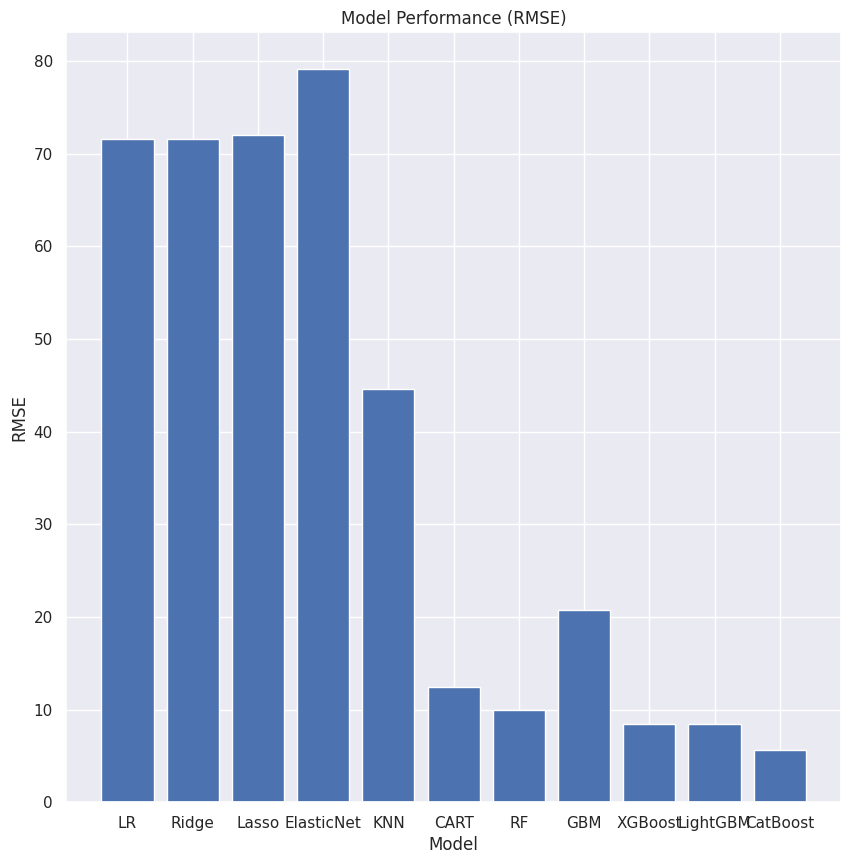

In [114]:
#Plot RMSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], rmse_scores)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Performance (RMSE)')
plt.show()

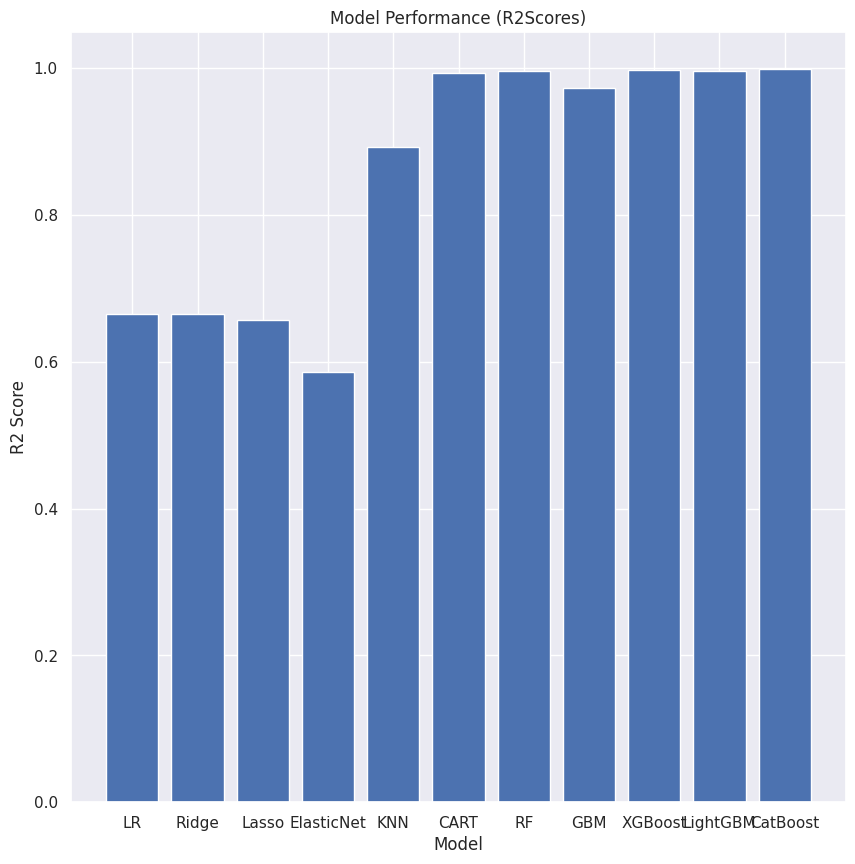

In [115]:
#Plot R2 scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], r2_scores)
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2Scores)')
plt.show()

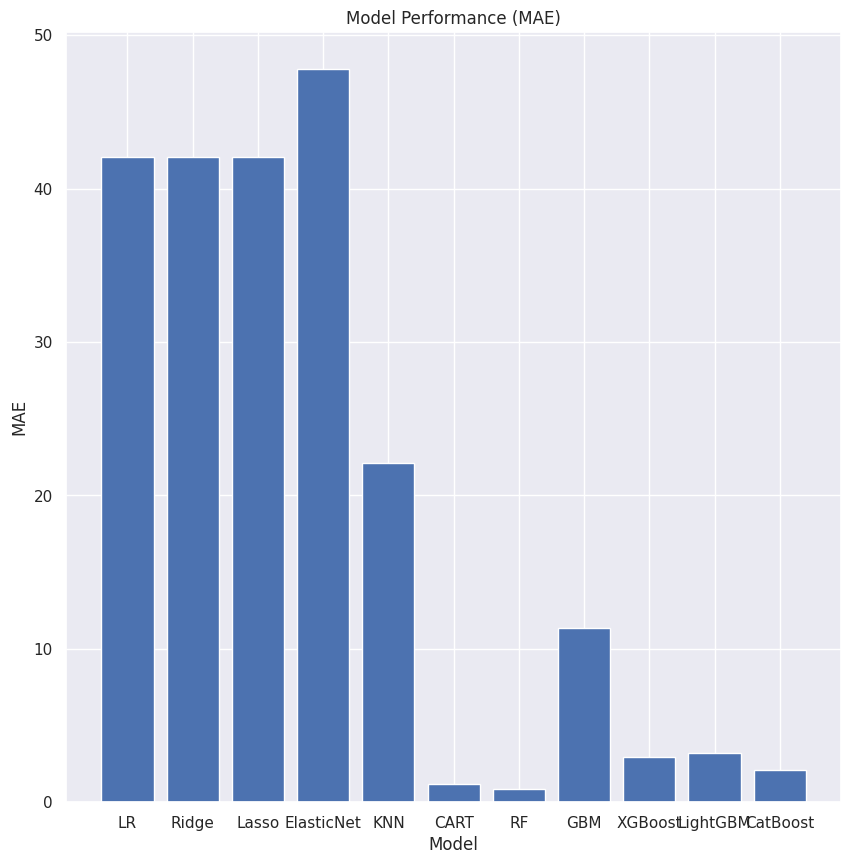

In [116]:
#Plot MAE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mae_scores)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Performance (MAE)')
plt.show()

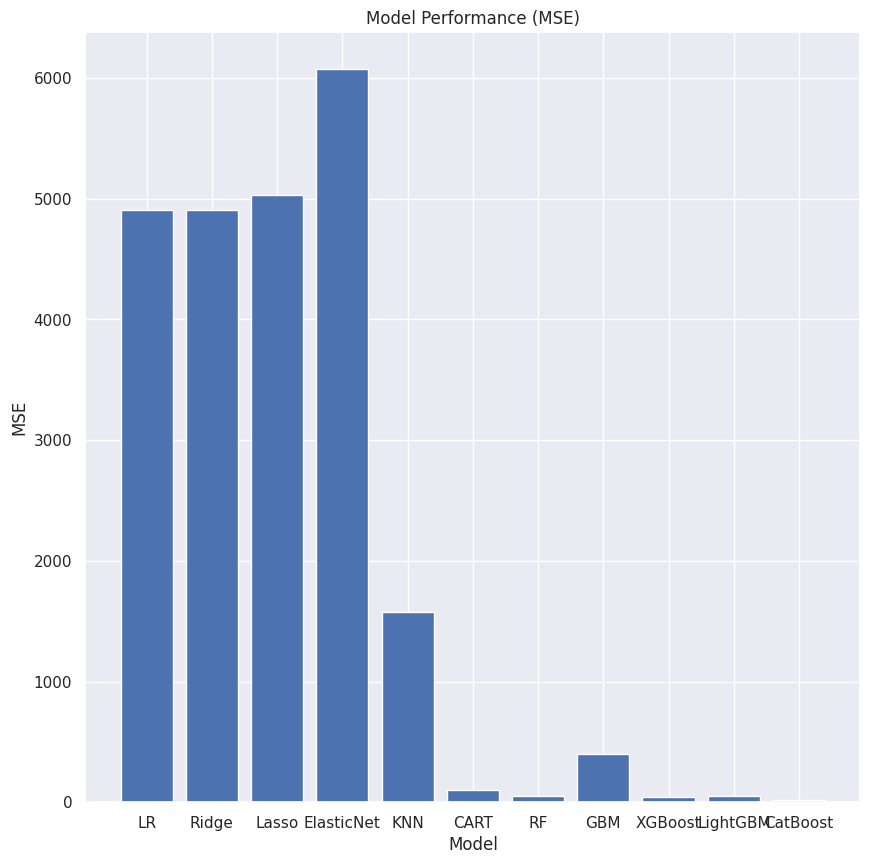

In [117]:
#Plot MSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mse_scores)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance (MSE)')
plt.show()

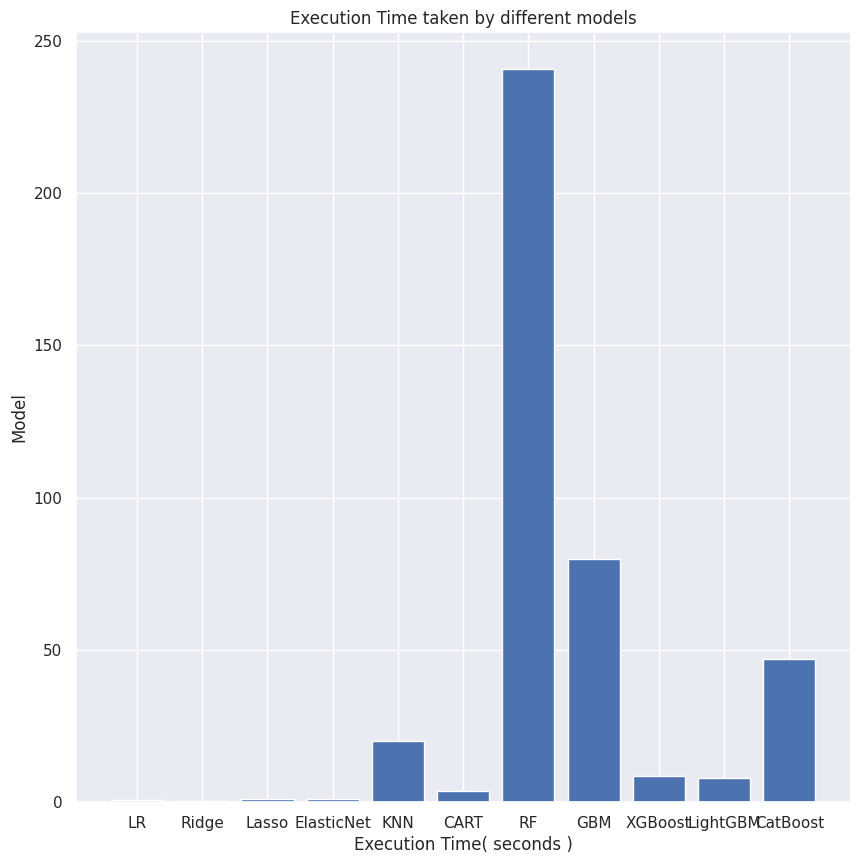

In [118]:
#Plot execution time
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], execution_times)
plt.xlabel('Execution Time( seconds )')
plt.ylabel('Model')
plt.title('Execution Time taken by different models')
plt.show()

# Hyperparameter optimization

In [125]:
models = [
    ('LR', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('RF', RandomForestRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('XGBoost', XGBRegressor(objective = 'reg:squarederror')),
    ('LightGBM', LGBMRegressor()),
    ('CatBoost', CatBoostRegressor(verbose = False))
]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []


params_grids = {
    'LR' : {},
    'Ridge': {'alpha': [0.1, 1.0]},
    'Lasso': {'alpha': [0.1, 1.0]},
    'ElasticNet' : {'alpha': [0.1, 1.0], 'l1_ratio' : [0.1, 0.9]},
    'KNN': {'n_neighbors': [3, 5]},
    'CART': {'max_depth': [None, 10],  'min_samples_leaf': [1, 2]},
    'RF' : {'n_estimators' : [10, 50], 'max_depth': [None, 10]},
    'GBM': {'n_estimators': [10, 50], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators' : [10, 50], 'learning_rate': [0.01, 0.1]},
    'LightGBM': {'n_estimators': [10, 50], 'learning_rate': [0.01, 0.1]},
    'CatBoost': {'iterations': [10, 50], 'learning_rate': [0.01, 0.1], 'depth': [4, 6]}
}


# Train and evaluate models

for name , regressor in models:
    print(f'Hyperparamter Tunings for {name}: ')
    start_time = time.time()
    
    if params_grids[name]:
        grid_search = GridSearchCV(regressor, param_grid = params_grids[name], cv = 5,n_jobs = -1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        print(f'Best paramters: {grid_search.best_params_}')
    else:
        best_model = regressor.fit(X_train, y_train)
        
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    # Calculate R2 Score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    # calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)
    
    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")
    
    

Hyperparamter Tunings for LR: 
RMSE: 70.0431 (LR)
R^2 Score: 0.6656 (LR)
MAE: 42.088 (LR)
MSE: 4906.0328 (LR)
Execution Time: 0.05 seconds

Hyperparamter Tunings for Ridge: 
Best paramters: {'alpha': 1.0}
RMSE: 70.0438 (Ridge)
R^2 Score: 0.6656 (Ridge)
MAE: 42.0872 (Ridge)
MSE: 4906.1288 (Ridge)
Execution Time: 0.42 seconds

Hyperparamter Tunings for Lasso: 
Best paramters: {'alpha': 0.1}
RMSE: 70.1052 (Lasso)
R^2 Score: 0.665 (Lasso)
MAE: 42.0402 (Lasso)
MSE: 4914.7403 (Lasso)
Execution Time: 3.03 seconds

Hyperparamter Tunings for ElasticNet: 
Best paramters: {'alpha': 0.1, 'l1_ratio': 0.9}
RMSE: 70.3563 (ElasticNet)
R^2 Score: 0.6626 (ElasticNet)
MAE: 42.0211 (ElasticNet)
MSE: 4950.0056 (ElasticNet)
Execution Time: 6.93 seconds

Hyperparamter Tunings for KNN: 
Best paramters: {'n_neighbors': 5}
RMSE: 39.7241 (KNN)
R^2 Score: 0.8924 (KNN)
MAE: 22.0858 (KNN)
MSE: 1578.0056 (KNN)
Execution Time: 25.45 seconds

Hyperparamter Tunings for CART: 
Best paramters: {'max_depth': None, 'min_sa

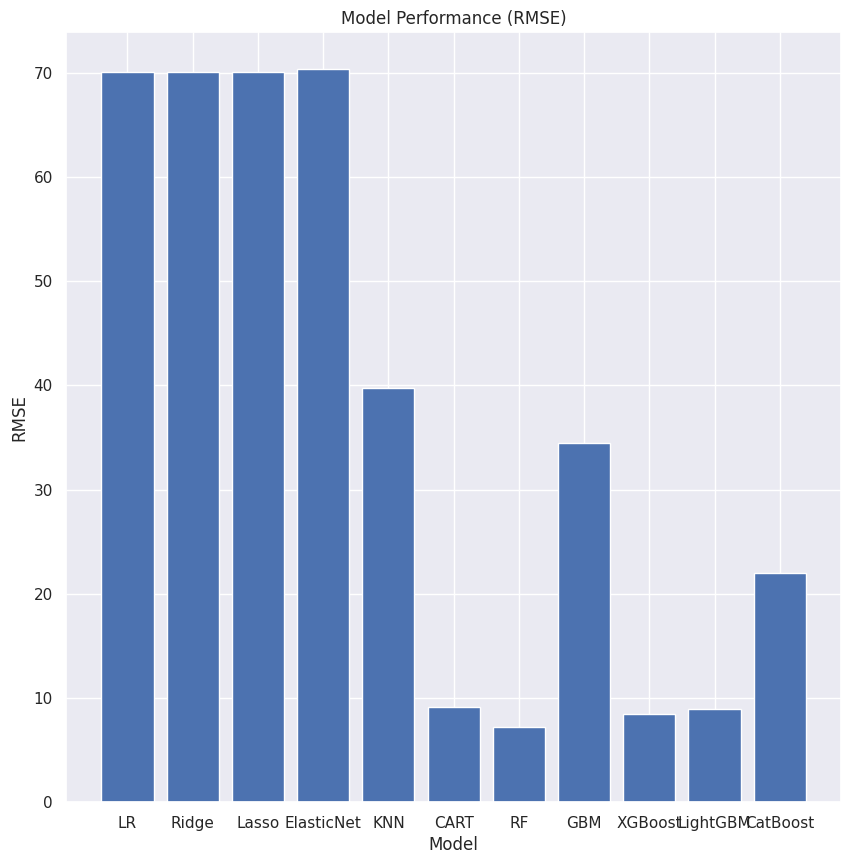

In [126]:
#Plot RMSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], rmse_scores)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Performance (RMSE)')
plt.show()

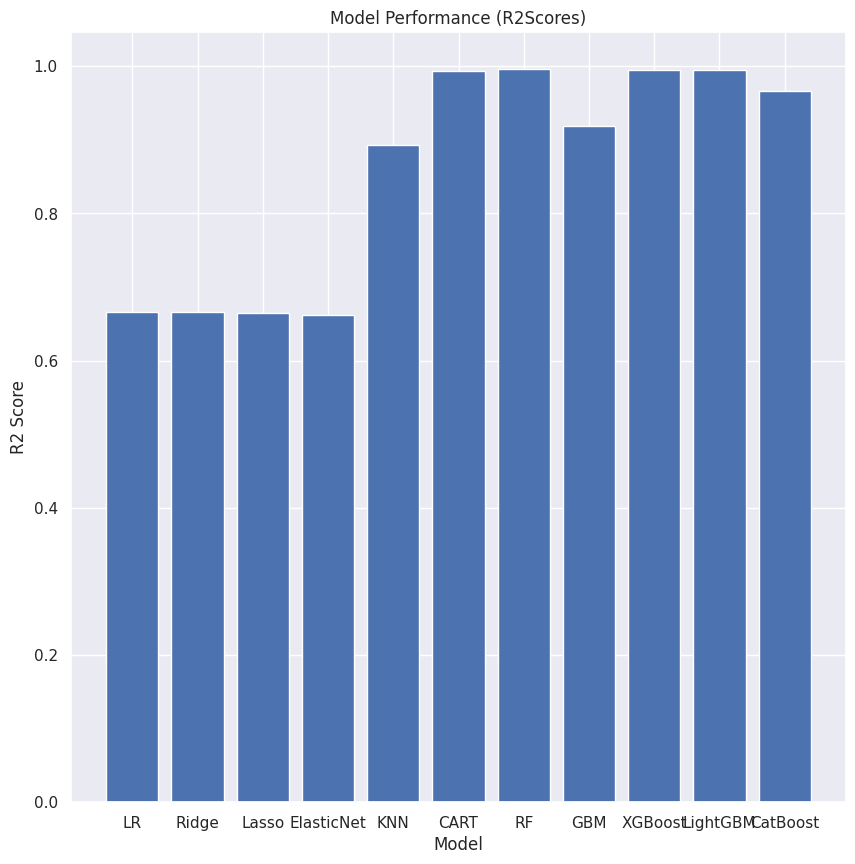

In [127]:
#Plot R2 scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], r2_scores)
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Performance (R2Scores)')
plt.show()

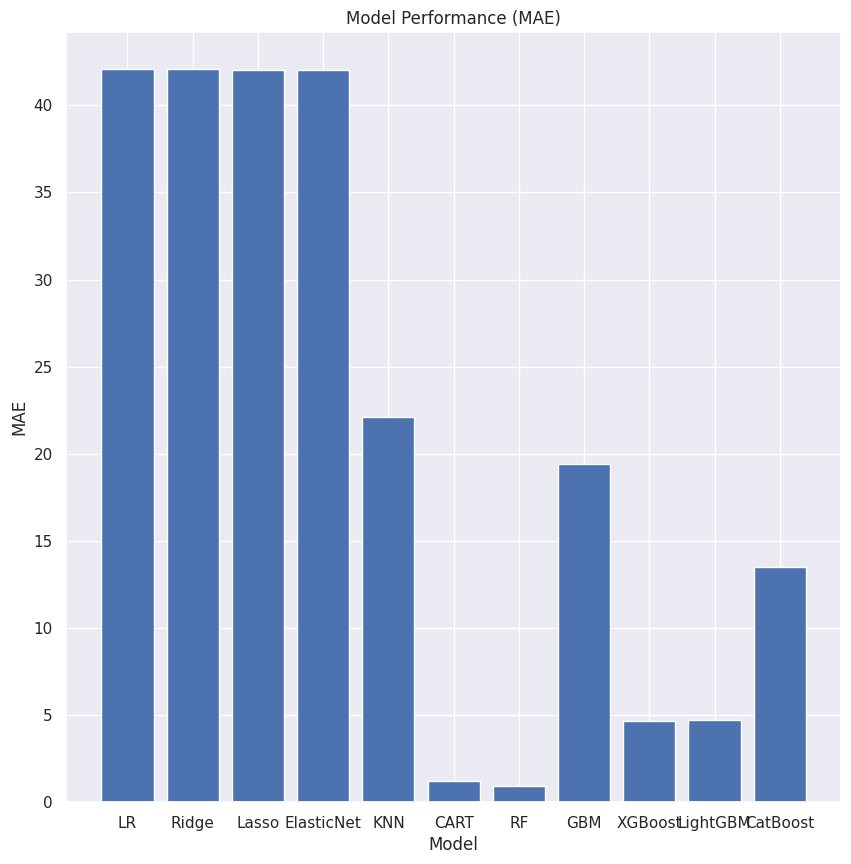

In [128]:
#Plot MAE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mae_scores)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Performance (MAE)')
plt.show()

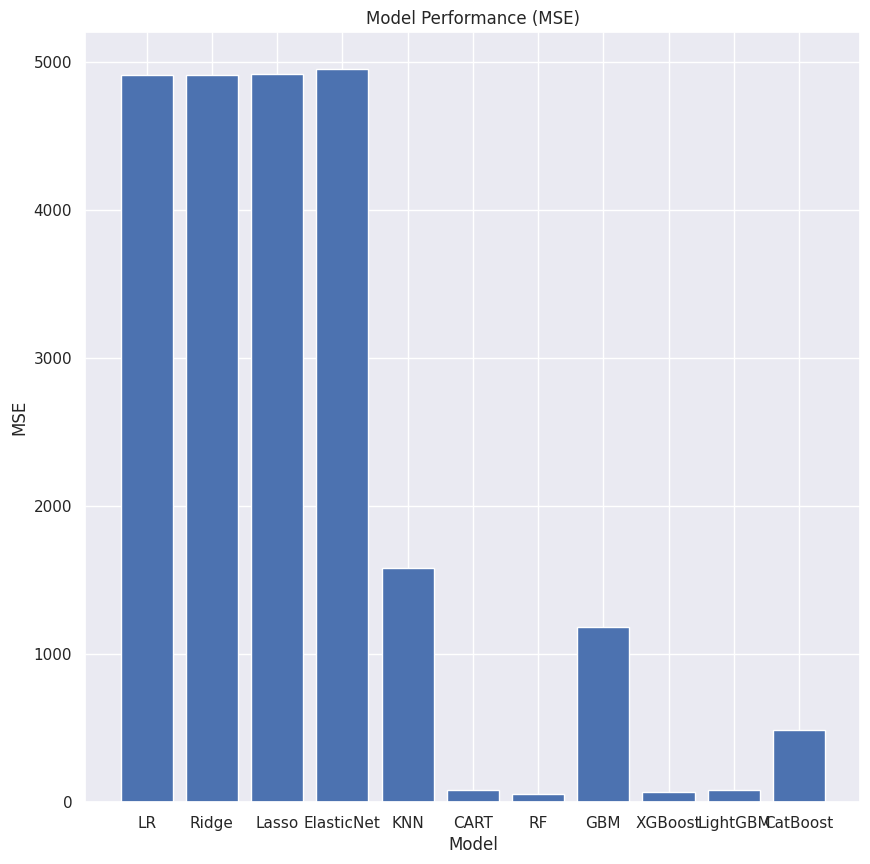

In [129]:
#Plot MSE scores
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], mse_scores)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance (MSE)')
plt.show()

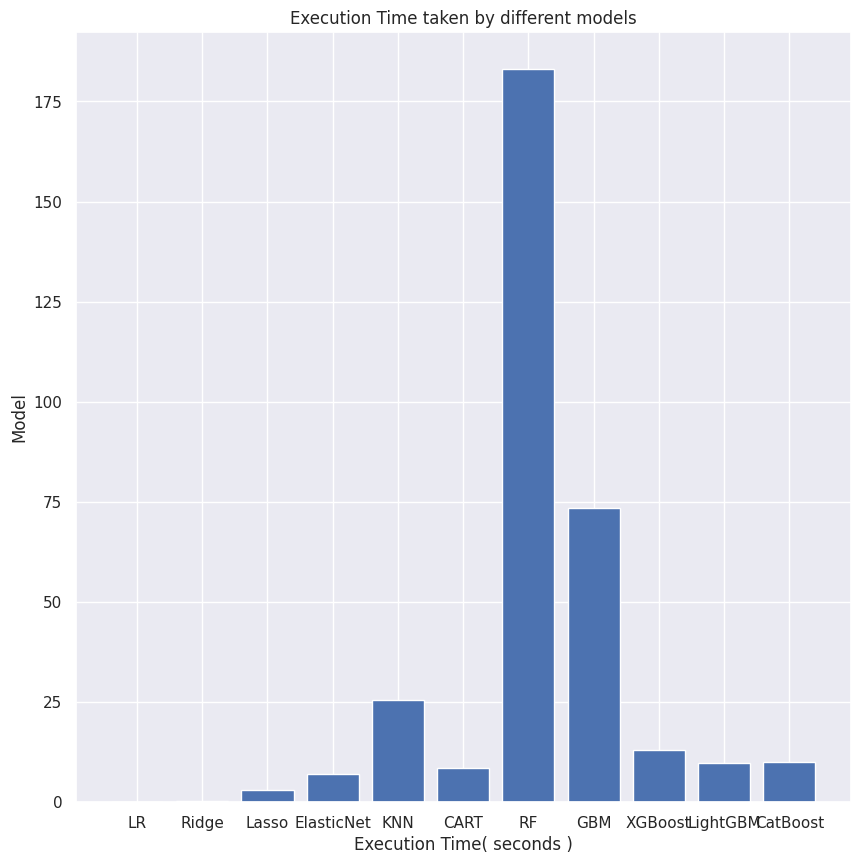

In [130]:
#Plot execution time
plt.figure(figsize=(10, 10))
plt.bar([name for name, _ in models], execution_times)
plt.xlabel('Execution Time( seconds )')
plt.ylabel('Model')
plt.title('Execution Time taken by different models')
plt.show()

# Final model Predictions and comaprison with true prices

In [131]:
best_model

In [132]:
final_model = best_model

y_final_pred = final_model.predict(X_test)
final_y_pred = (y_final_pred)
final_y_test = (y_test)

results = pd.DataFrame({'Predicted Price': final_y_pred, 'True Price': final_y_test})

results['Difference'] = results['True Price'] - results['Predicted Price']

print(results)

       Predicted Price  True Price  Difference
2472           126.326     135.000       8.674
34556           92.806     100.000       7.194
34771           45.922      39.000      -6.922
48617           69.104      80.000      10.896
11574          150.728     150.000      -0.728
...                ...         ...         ...
24079          418.112     375.000     -43.112
39454          124.731     120.000      -4.731
12582          191.450     220.000      28.550
10308          147.850     200.000      52.150
6586            72.761      80.000       7.239

[9779 rows x 3 columns]


# Feature Importance

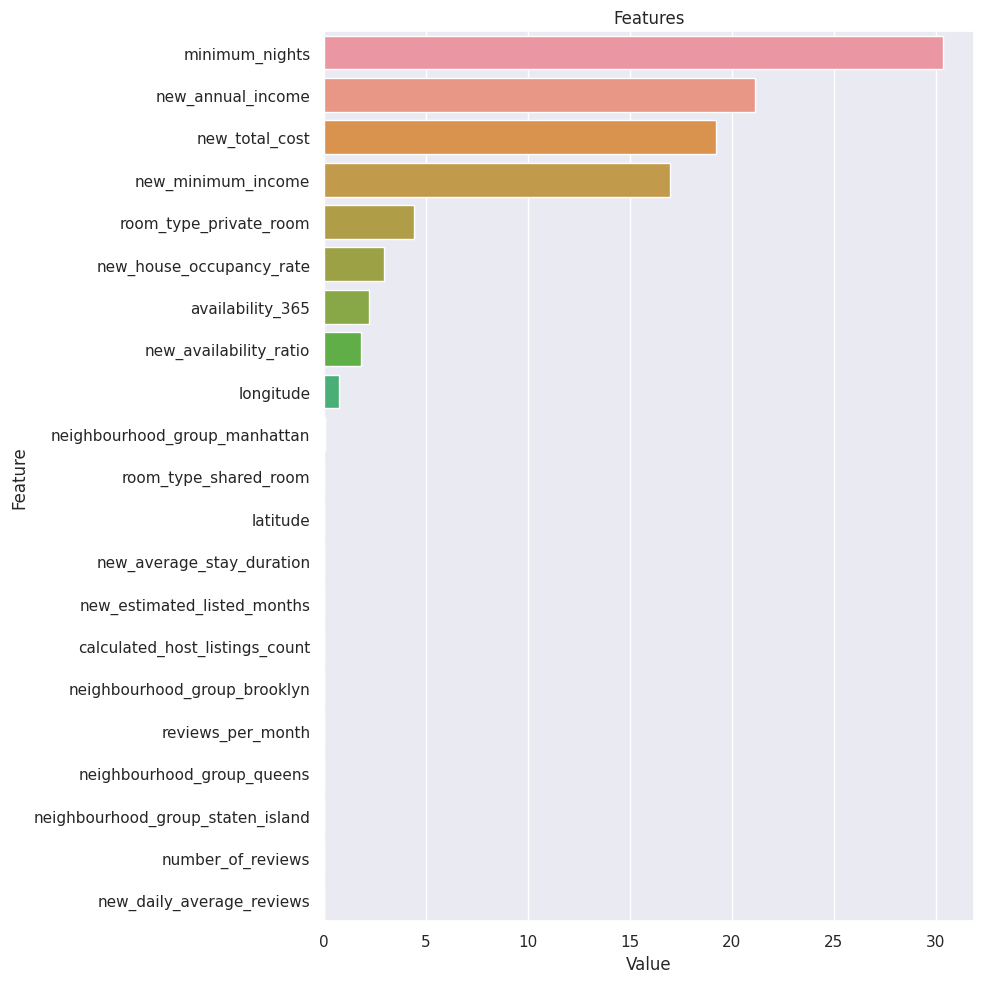

In [133]:
def plot_importance(model, features, num=50, save = False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_,
                               'Feature': features.columns
                               })
    plt.figure(figsize=(10, 10))
    sns.set(font_scale = 1)
    sns.barplot(
        x = 'Value',
        y = 'Feature',
        data = feature_imp.sort_values(by = 'Value', ascending = False)[0:num]
    )
    plt.title('Features')
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig('importances.png')
    
plot_importance(final_model, X)

# Reference

https://www.kaggle.com/code/mehmetisik/airbnb-nyc-eda-price-prediction-ml